In [1]:
import tables as tb
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import invisible_cities.io.dst_io as dio

import matplotlib.pyplot as plt
from   mpl_toolkits.mplot3d import Axes3D
from utils.plotting_utils import plot_adaption_hits_to_voxel_scale, plot_cloud_voxels_and_hits, plot_3d_hits, plot_3d_vox
from utils.plotting_utils import plot_label_creator

# Abrimos un archivo

In [2]:
basedir = '/Users/mperez/NEXT/data_labelling/examples/'

In [3]:
labelled_file = basedir + 'h5files/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_label_4mm_fid.h5'

In [4]:
labelled_MC_voxels = dio.load_dst(labelled_file, 'DATASET', 'MCVoxels')
labelled_MC_hits   = dio.load_dst(labelled_file, 'DATASET', 'MCHits')
labelled_beersheba_voxels = dio.load_dst(labelled_file, 'DATASET', 'BeershebaVoxels')
eventInfo = dio.load_dst(labelled_file, 'DATASET', 'EventsInfo')
binsInfo  = dio.load_dst(labelled_file, 'DATASET', 'BinsInfo')

In [5]:
voxel_size = (binsInfo.size_x.values[0], binsInfo.size_y.values[0], binsInfo.size_z.values[0])
total_size = (binsInfo.total_x.values[0], binsInfo.total_y.values[0], binsInfo.total_z.values[0])
start_bin  = (binsInfo.min_x.values[0], binsInfo.min_y.values[0], binsInfo.min_z.values[0])

In [6]:
idx = 192
event_MC_vox = labelled_MC_voxels[labelled_MC_voxels.dataset_id == idx]
event_MC_hits = labelled_MC_hits[labelled_MC_hits.dataset_id == idx]
event_beersh_vox = labelled_beersheba_voxels[labelled_beersheba_voxels.dataset_id == idx]

In [7]:
original_file = basedir + 'h5files/' + eventInfo[eventInfo.dataset_id == idx].basename.values[0]

In [8]:
event_id = eventInfo[eventInfo.dataset_id == idx].event_id.values[0]

In [9]:
MC_particles = dio.load_dst(original_file, 'MC', 'particles')
MC_hits = dio.load_dst(original_file, 'MC', 'hits')

In [10]:
origevent_MC_hits = MC_hits[MC_hits.event_id == event_id]

In [11]:
origevent_MC_particles = MC_particles[MC_particles.event_id == event_id]

<IPython.core.display.Javascript object>


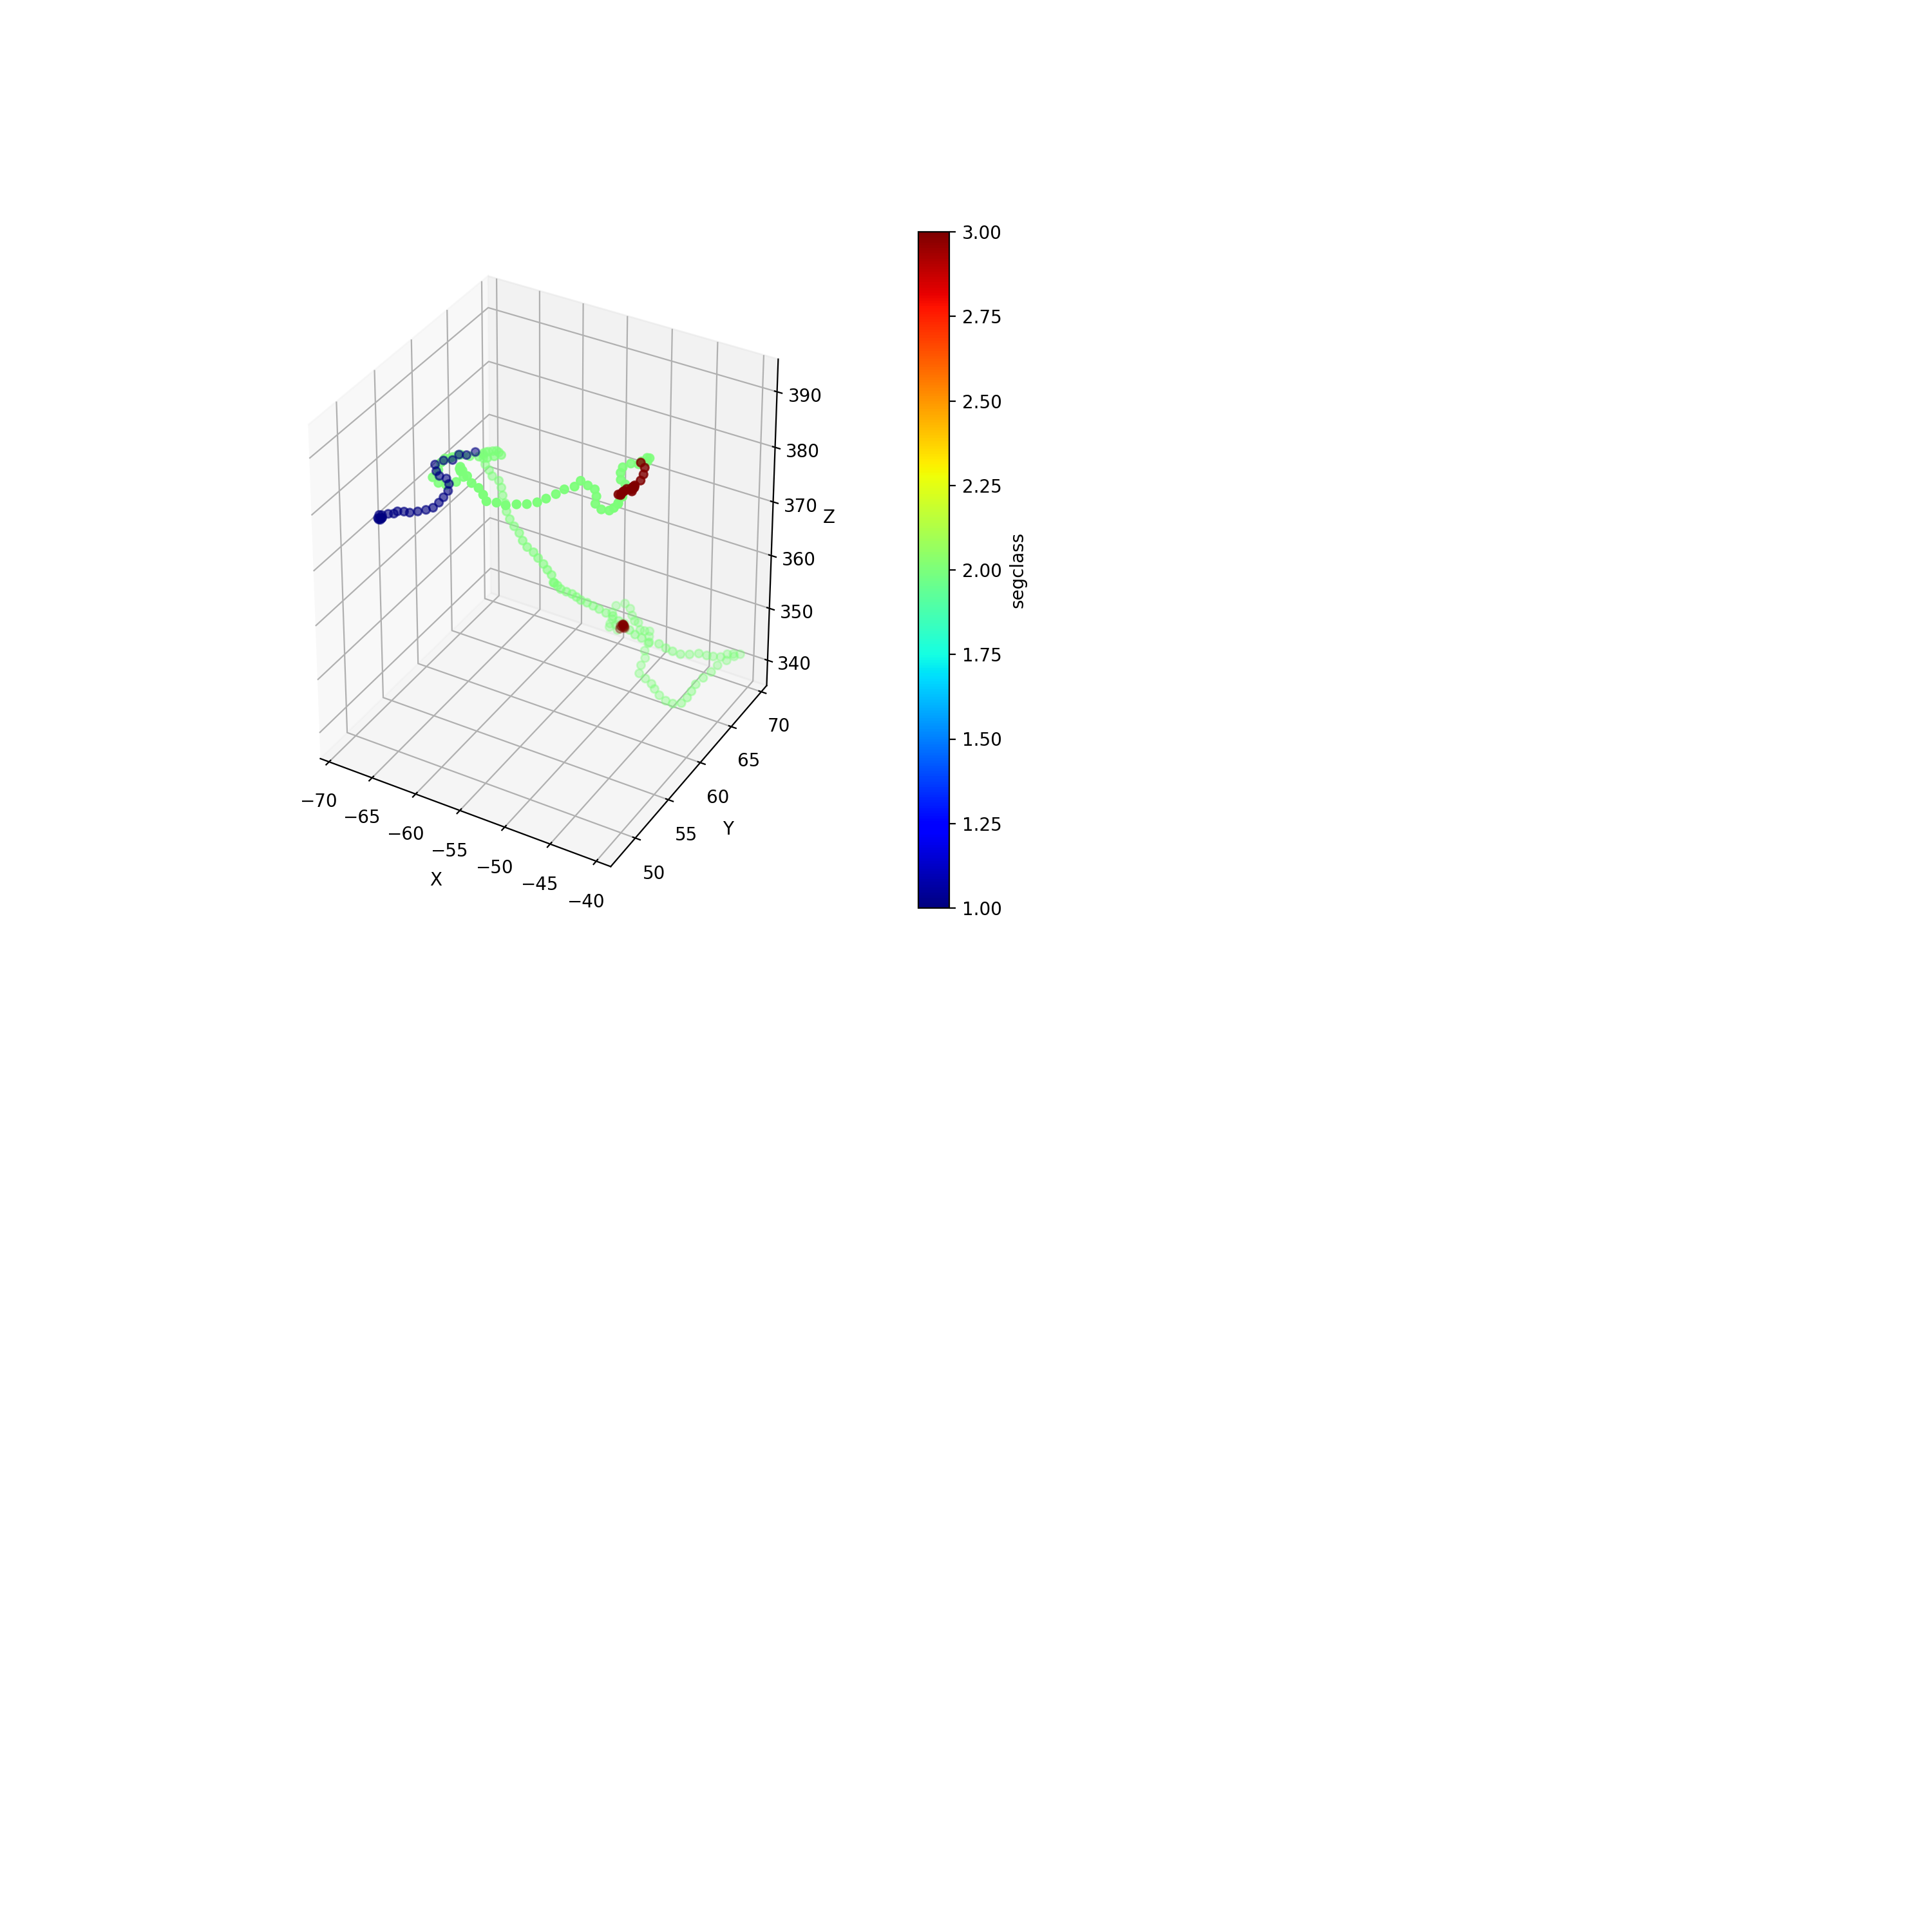

<IPython.core.display.Javascript object>


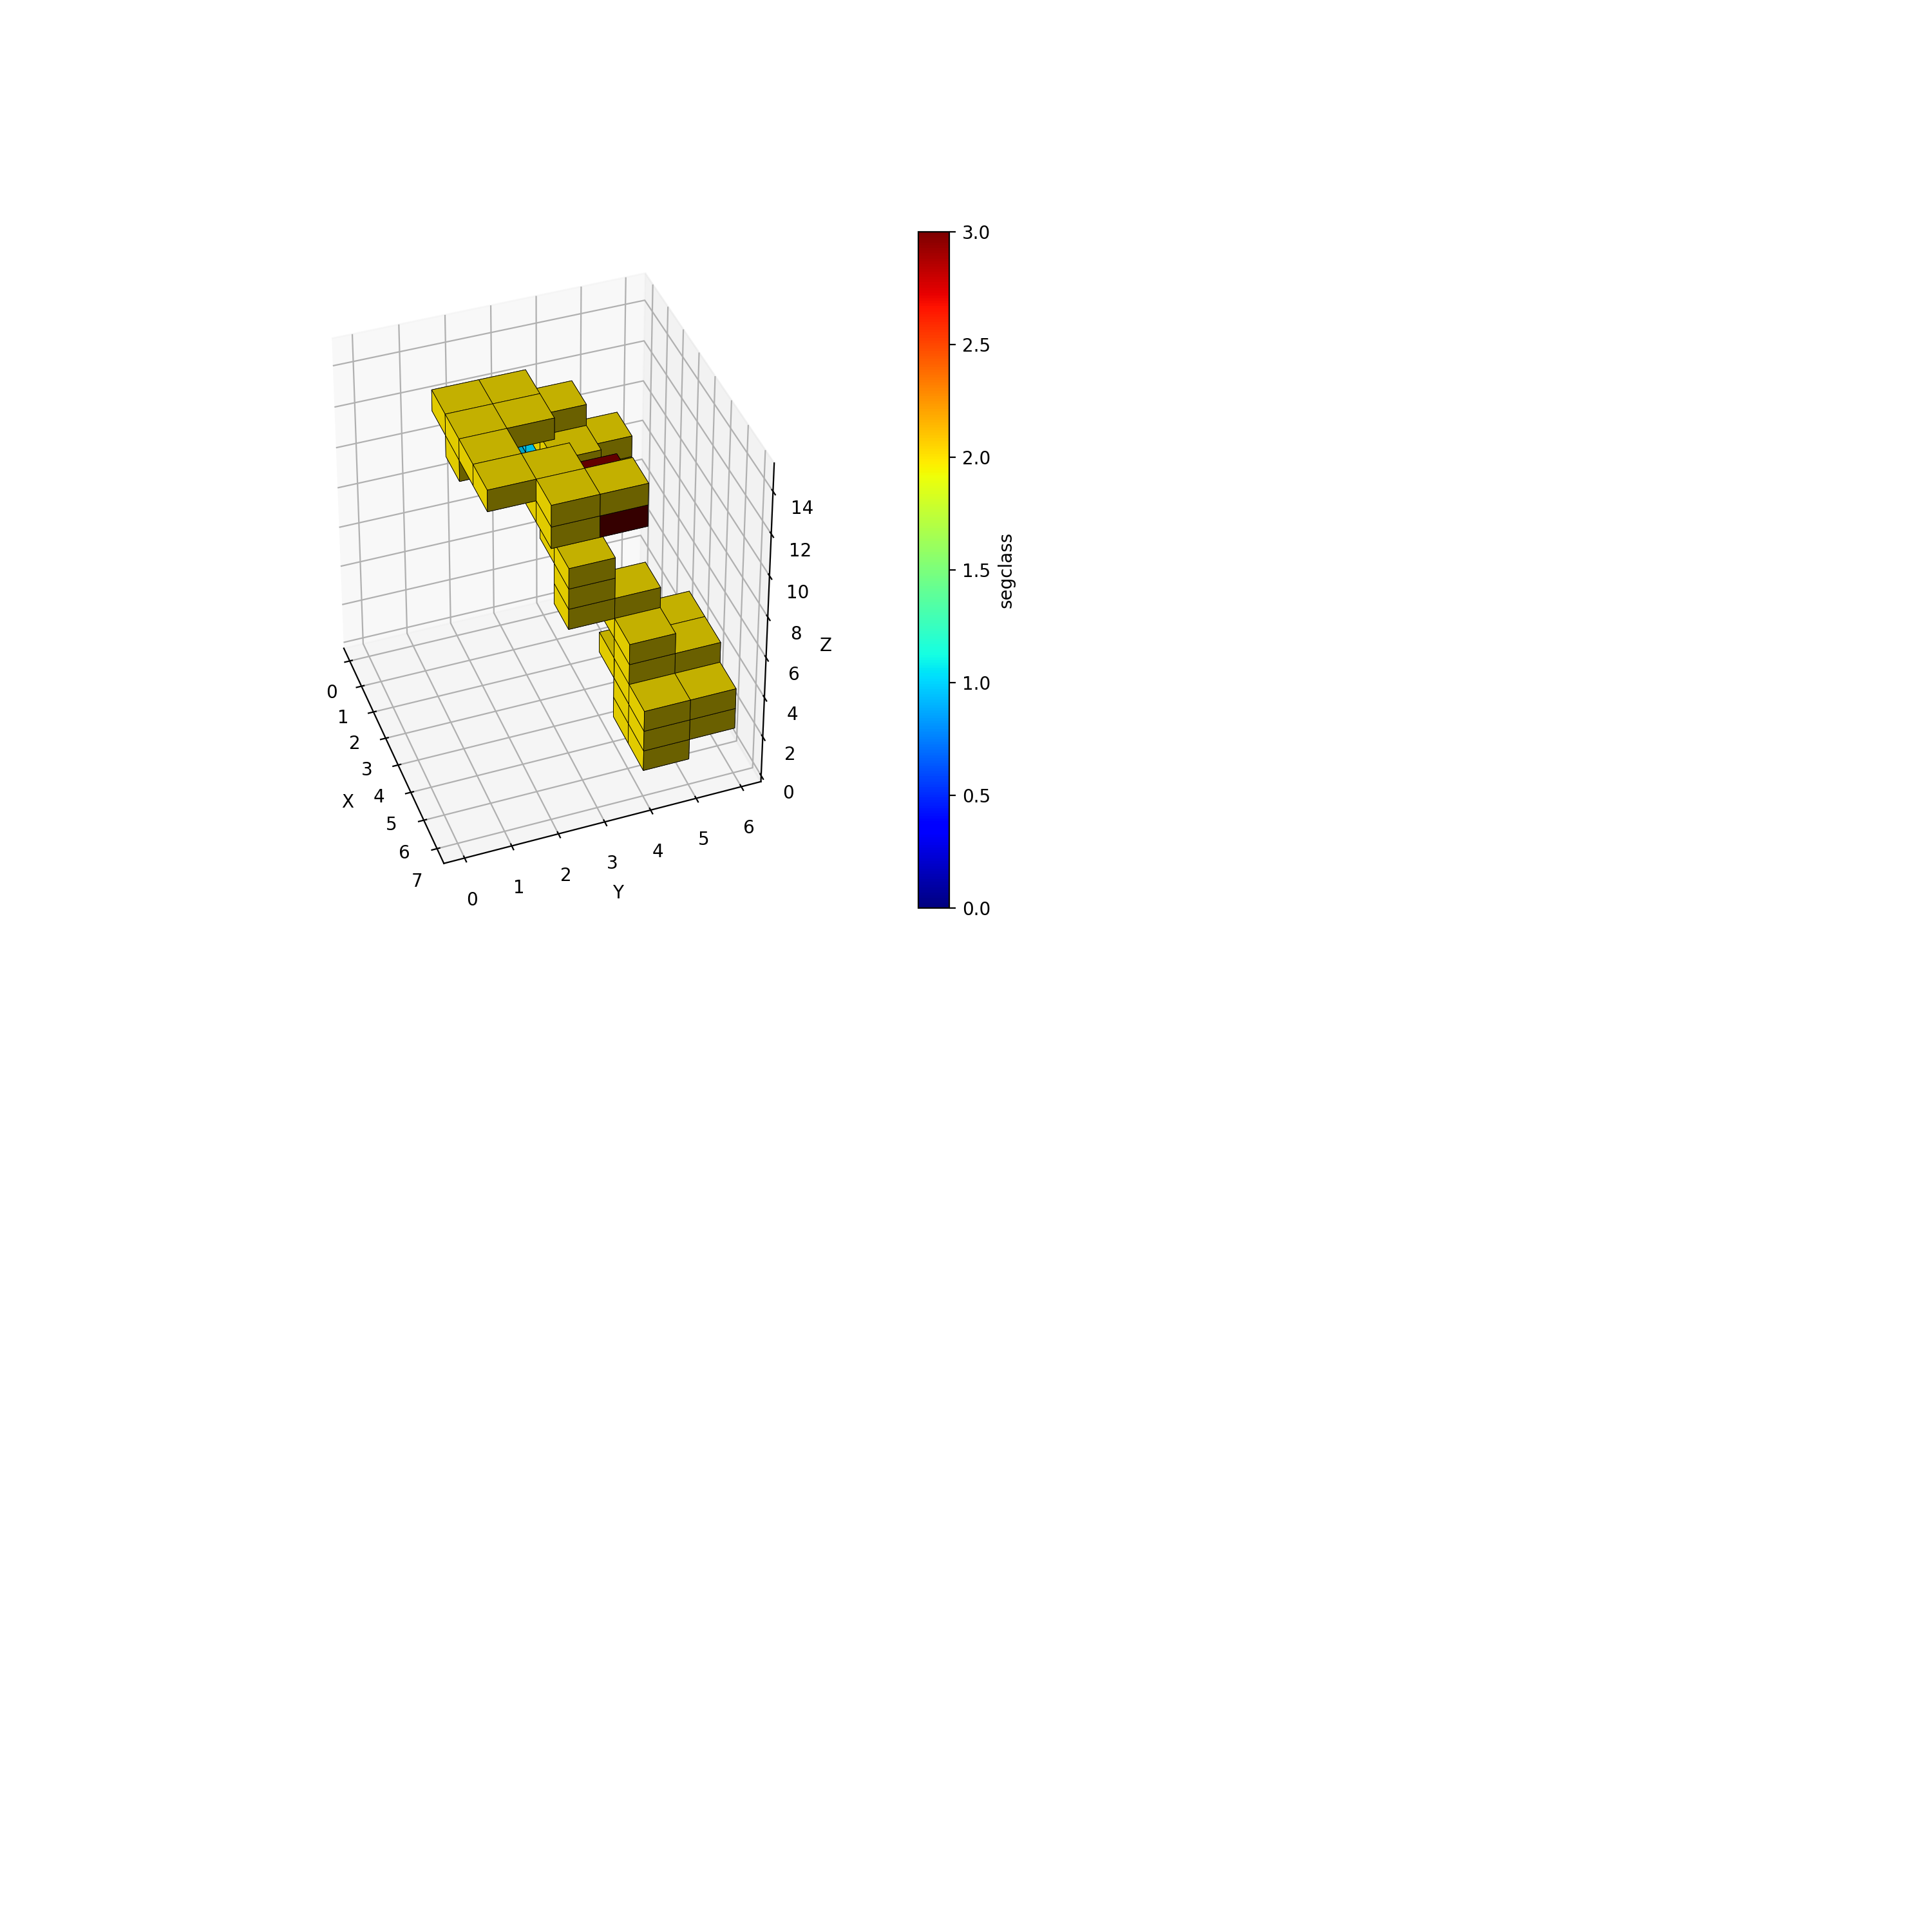

In [12]:
%matplotlib notebook
#plot_3d_hits(origevent_MC_hits, value = 'particle_id')
plot_3d_hits(event_MC_hits, value = 'segclass')
plot_3d_vox(event_MC_vox, value = 'segclass')
#plot_cloud_voxels_and_hits(event_MC_vox, event_MC_hits, voxel_size, value = ['segclass', 'segclass', 'segclass'], coords = ['x', 'y', 'z'])



# Corregimos los datos de 1e que no tenían ningun blob

Esto, después de unas vueltas conseguí ver que era porque en la función segclass sólo seleccionaba electrones de compton, y había algunos eventos de efecto fotoelectrico q dejaban trazas, entonces añadí eso y listo

In [13]:
from utils.labelling_utils import add_binclass, add_segclass, add_hits_labels_MC, calculate_track_distances

In [50]:
binclass_hits = add_binclass(MC_hits, MC_particles)

In [51]:
def add_segclass(mchits, mcpart, delta_loss = None, delta_e = None, label_dict={'rest':1, 'track':2, 'blob':3}): 
    '''
    Add segmentation class to each hit in the file, after being filled with the binclass.
    The classes are 1 - rest, 2 - track, 3 - blob.
    Rest class is assigned to every hit that is not in the main tracks. Track class is assigned to the
    hits of the  e- and e+ that come from a gamma conversion process (defined like that in Geant4) in the 
    double scape case, and to the most energetic e- from a compton scattering proccess / photoelectric effect. 
    Finally, the blob class is chosen for the last hits of the track events that fulfill a specific condition 
    given either by delta_loss argument of the function or delta_e (explained in the Args part).
    It also computes the distance between the hits of the tracks (we take advantage of the tracks info 
    extraction being done here to perform this calculation)
    
    Args:
        mchits: DATAFRAME
    Contains the hits information plus the binclass. It is the output of the add_binclass() function.
    
        mcpart: DATAFRAME
    Contains the particle information.
    
        delta_loss: FLOAT
    Energy loss threshold in percentage (respect to the total track energy) for the last hits of a 
    track to become blob class.
    
        delta_e: FLOAT
    Energy threshold for the last hits of a track to become blob class.
    
        label_dict: DICTIONARY
    Has the correspondence for the class names.
    
    RETURN:
        hits_label: DATAFRAME
    Contains the hits information with event_id, coordinates, energy, segclass, binclass
    and hits distances of the tracks (also creator and particle to get the traces and do the bragg peak study)
    
    '''
    #Unimos los df de hits y particulas, haciendo que a cada hit de mchits se le añada la información 
    #de la partícula que viene en mcpart
    hits_part = pd.merge(mchits, mcpart, on = ['event_id', 'particle_id']) 
    
    #Agrupamos todos los hits de cada partícula de cada evento y sumamos su energía para obtener la
    #energía depositada por cada partícula (más otra información)
    per_part_info = hits_part.groupby(['event_id', 
                                       'particle_id', 
                                       'particle_name', 
                                       'creator_proc']).agg({'energy':[('track_ener', sum)]})
    per_part_info.columns = per_part_info.columns.get_level_values(1)
    per_part_info.reset_index(inplace=True)
    
    #Seleccionamos los eventos de double scape y background
    doublescape_event_ids = per_part_info[per_part_info.particle_name == 'e+'].event_id.unique()
    background_event_ids  = np.setdiff1d(per_part_info.event_id.unique(), doublescape_event_ids)
    
    #Seleccionamos las trazas de cada evento
    #Para double scape es sencillo, cogemos los e+e- cuyo proceso de creación sea conv, tendremos 2 trazas/evento
    tracks_dsc = per_part_info[(per_part_info.event_id.isin(doublescape_event_ids)) &\
                                   (per_part_info.particle_name.isin(['e+', 'e-']) &\
                                   (per_part_info.creator_proc == 'conv'))]
    
    #Para background cogemos los electrones que fueron creados por compton, y de ellos escogemos el más energético
    #Tendremos 1 traza/evento
    tracks_bkg = per_part_info[(per_part_info.event_id.isin(background_event_ids)) &\
                                   (per_part_info.particle_name == 'e-') &\
                                   (per_part_info.creator_proc.isin(['compt', 'phot']))]
    
    tracks_bkg = tracks_bkg.loc[tracks_bkg.groupby('event_id').track_ener.idxmax()] #seleccionamos el más energético
    
    #Unimos la información de todas las trazas y le añadimos la etiqueta track en una nueva columna segclass
    tracks_info = pd.concat([tracks_bkg, tracks_dsc]).sort_values('event_id')
    tracks_info = tracks_info.assign(segclass = label_dict['track'])
    
    #Añadimos al df de información de hits y partículas la nueva columna de etiquetas de voxel
    hits_part  = hits_part.reset_index()
    hits_label = hits_part.merge(tracks_info[['event_id', 'particle_id', 'track_ener', 'segclass']], 
                                 how='outer', on=['event_id', 'particle_id'])
    
    #Todas las partículas que ahora en segclass no tienen valor se les adjudica la etiqueta rest
    hits_label.segclass = hits_label.segclass.fillna(label_dict['rest']) 
    
    #Ordeno los hits en orden descendente y hago suma cumulativa de energías de hit en una columna, cumenergy
    hits_label = hits_label.sort_values(['event_id', 'particle_id', 'hit_id'], ascending=[True, True, False])
    hits_label = hits_label.assign(cumenergy = hits_label.groupby(['event_id', 'particle_id']).energy.cumsum())
    
    #Creo la columna de porcentaje de energía perdida
    hits_label = hits_label.assign(lost_ener = (hits_label.cumenergy / hits_label.track_ener).fillna(0))
    
    if delta_e is not None:
        #Escojo los hits que de forma acumulada sumen menos de delta_e energía
        blob_mask = (hits_label.cumenergy < delta_e)
    
    if delta_loss is not None:
        #Escojo los hits según hayan perdido un porcentaje determinado de energía de su total
        #Primero calculo la energía total de cada traza
        blob_mask = (hits_label.lost_ener < delta_loss)
    
    if delta_e == None and delta_loss == None:
        raise ValueError('Neither delta_e nor delta_loss has been given a value to define the blobs')
        
    #Ahora, dentro de todos los hits, escojo los últimos hits de clase track que sumen menos de delta_e
    hits_label.loc[(hits_label.segclass==label_dict['track'])& blob_mask, 'segclass'] = label_dict['blob']
    
    #Calculo la distancia entre hits de las trazas y lo añado al df de información que tenía
    hits_label_dist = calculate_track_distances(tracks_info, hits_label)
    
    #Escojo solo la información que me interesa
    hits_label_dist = hits_label_dist[['event_id', 'x', 'y', 'z', 'hit_id', 'particle_id', 'energy', 'segclass', 'binclass', 'dist_hits', 'cumdist', 'particle_name', 'creator_proc']].reset_index(drop=True)
    
    return hits_label_dist

In [42]:
segclass_hits = add_segclass(binclass_hits, MC_particles, delta_loss=0.25)

In [24]:
segclass_hits

event_id           x           y           z  hit_id  particle_id  \
0       48000024  -20.396835  110.981293  260.250183       0            8   
1       48000024   59.417656  169.880173  347.795013       1            8   
2       48000024  -20.687016  110.034622  260.143280       0           11   
3       48000024  -21.286871  109.238541  260.130890       1           11   
4       48000024  -21.929659  108.488617  260.021271       2           11   
...          ...         ...         ...         ...     ...          ...   
138849  48000575 -124.227226   74.766670  429.902863       0           30   
138850  48000575 -124.231659   74.779442  429.880554       1           30   
138851  48000575 -124.231750   74.781944  429.880554       2           30   
138852  48000575 -124.202446   68.991394  434.560577       0           31   
138853  48000575 -124.202660   68.993156  434.559723       0           32   

          energy  segclass  binclass  dist_hits   cumdist particle_name  \
0       0.005417       1.0         0   0.000000  0.000000         gamma   
1       0.000927       1.0         0   0.000000  0.000000         gamma   
2       0.004358       2.0         0   0.000000  0.000000            e-   
3       0.004584       2.0         0   0.996858  0.996858            e-   
4       0.005005       2.0         0   0.993770  1.990628            e-   
...          ...       ...       ...        ...       ...           ...   
138849  0.025559       1.0         0   0.000000  0.000000            e-   
138850  0.012715       1.0         0   0.000000  0.000000            e-   
138851  0.003305       1.0         0   0.000000  0.000000            e-   
138852  0.001122       1.0         0   0.000000  0.000000         gamma   
138853  0.002772       1.0         0   0.000000  0.000000            e-   

            creator_proc  
0       RadioactiveDecay  
1       RadioactiveDecay  
2                  compt  
3                  compt  
4                  compt  
...                  ...  
138849             eIoni  
138850             eIoni  
138851             eIoni  
138852             eBrem  
138853              phot  

[138854 rows x 13 columns]

<IPython.core.display.Javascript object>


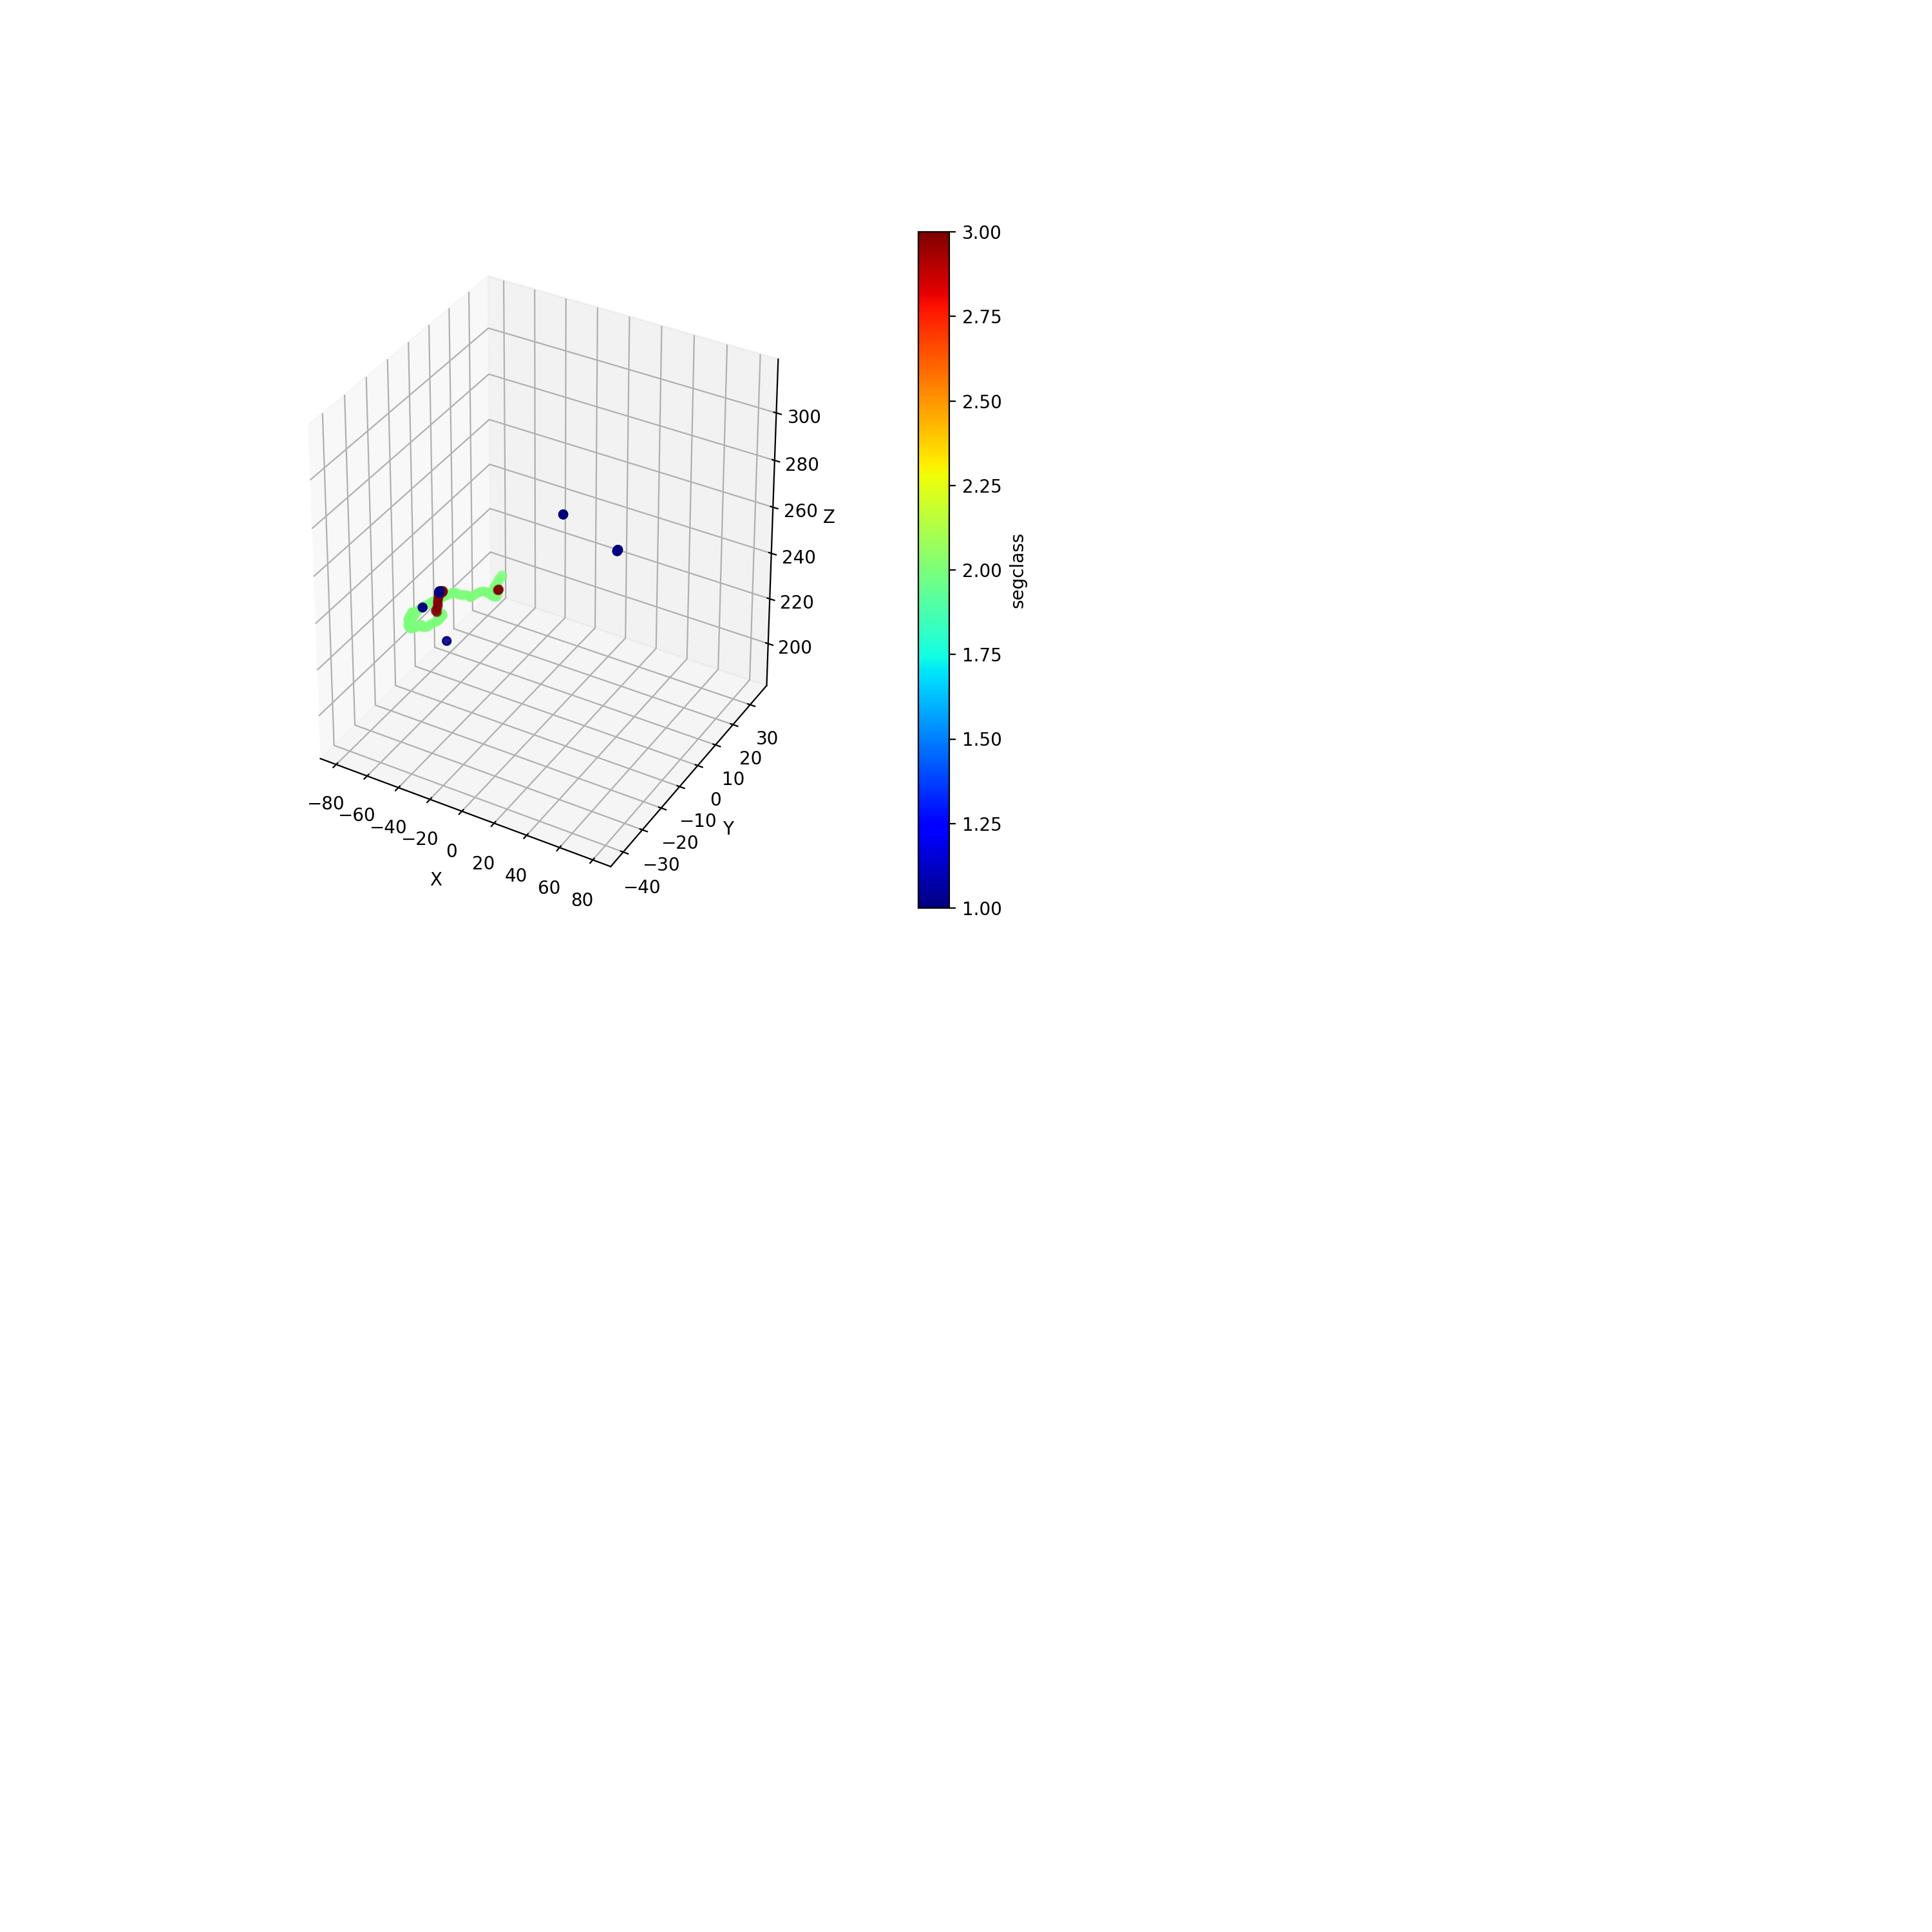

In [35]:
plot_3d_hits(segclass_hits[segclass_hits.event_id == event_id], value = 'segclass')

# Corregir eventos a los que le falta algún blob en general (problema con los hits etiquetados de blob pero poca energía)

Me di cuenta de que al usar mi método de etiquetar trazas tomando los hits del final de la traza que hubieran depositado cierto % de energía respecto a la total, había partículas poco energéticas que etiquetaban pocos hits como blob y por tanto cuando se voxelizaba no había forma de que los hits de blob se impusieran sobre otros, y no aparecían en la voxelización. Sucedía sobre todo para los eventos double scape, ya que había una partícula que se llevaba más energía que la otra y a veces la diferencia era grande... dejando a una de las partículas con poca energía.

Lo que hice para solucionarlo fue aplicar que si los hits etiquetados como blob de cierta partícula no llegaban a cierto threshold (small_blob_th), serían marcados como small blobs y obligados a prevalecer sobre otros hits en el voxelizado. El valor que puse inicialmente es 0.1, pero tras explorar algo más otros eventos lo más seguro es que al final ponga algo más elevado, sobre 0.15 o 0.2... veremos.

Aún así de la última exploración surgió otro problema al ver que alguna vez una de las dos partículas deposita tan pocos hits que no se llega a poder hacer lo del % de energía... porque simplemente quizás si hay 2 hits, el último deposita el 70% de la energía y ya se sale de nuestro 25% con el que hice el etiquetado...

Ahora mismo lo que se me ocurre hacer es mirar el ratio entre la energía de una partícula y de otra, y si se cumple que sea mucho mayor o lo que sea, directamente etiquetar todos los hits de la partícula pequeña como blob y santas pascuas... es que prácticamente surje y se para, no le da para más!!

In [35]:
def add_small_blob_mask(labelled_hits, small_blob_th = 0.1):
    '''
    Takes the add_hits_labels_MC output and creates a mask that marks all the small blob hits to make sure 
    afterwards that they get representation in the voxelization.
    
    Args:
        labelled_hits: DATAFRAME
    Output of the add_hits_label_MC function.
    
        small_blob_th: FLOAT
    Threshold for the energy of a group of blob hits to become marked.
    
    RETURNS:
        labelled_hits: DATAFRAME
    The same as in the input, but with a new column called small_b with the mask.
    '''
    
    per_label_info = labelled_hits.groupby(['event_id',
                                        'particle_id',
                                        'segclass']).agg({'energy':[('group_ener', sum)]})
    per_label_info.columns = per_label_info.columns.get_level_values(1)
    per_label_info.reset_index(inplace=True)
    
    sb_mask = ((per_label_info.group_ener < small_blob_th) & (per_label_info.segclass == 3)).values
    per_label_info['small_b'] = sb_mask
    
    labelled_hits = labelled_hits.merge(per_label_info, on = ['event_id', 'particle_id', 'segclass'])
    
    return labelled_hits

In [43]:
segclass_hits = add_small_blob_mask(segclass_hits)

In [31]:
small_blob_th = 0.1

### Pruebas para crear la función add_small_blob_class

In [32]:
labelled_hits = segclass_hits.copy()

In [33]:
#agrupo los hits por partícula y por label
per_label_info = labelled_hits.groupby(['event_id',
                                        'particle_id',
                                        'segclass']).agg({'energy':[('group_ener', sum)]})
per_label_info.columns = per_label_info.columns.get_level_values(1)
per_label_info.reset_index(inplace=True)

In [34]:
sb_mask = ((per_label_info.group_ener < small_blob_th) & (per_label_info.segclass == 3)).values

In [203]:
per_label_info['small_b'] = sb_mask

In [204]:
labelled_hits

event_id           x           y           z  hit_id  particle_id  \
0       48000024  -20.396835  110.981293  260.250183       0            8   
1       48000024   59.417656  169.880173  347.795013       1            8   
2       48000024  -20.687016  110.034622  260.143280       0           11   
3       48000024  -21.286871  109.238541  260.130890       1           11   
4       48000024  -21.929659  108.488617  260.021271       2           11   
...          ...         ...         ...         ...     ...          ...   
138849  48000575 -124.227226   74.766670  429.902863       0           30   
138850  48000575 -124.231659   74.779442  429.880554       1           30   
138851  48000575 -124.231750   74.781944  429.880554       2           30   
138852  48000575 -124.202446   68.991394  434.560577       0           31   
138853  48000575 -124.202660   68.993156  434.559723       0           32   

          energy  segclass  binclass  dist_hits   cumdist particle_name  \
0       0.005417       1.0         0   0.000000  0.000000         gamma   
1       0.000927       1.0         0   0.000000  0.000000         gamma   
2       0.004358       2.0         0   0.000000  0.000000            e-   
3       0.004584       2.0         0   0.996858  0.996858            e-   
4       0.005005       2.0         0   0.993770  1.990628            e-   
...          ...       ...       ...        ...       ...           ...   
138849  0.025559       1.0         0   0.000000  0.000000            e-   
138850  0.012715       1.0         0   0.000000  0.000000            e-   
138851  0.003305       1.0         0   0.000000  0.000000            e-   
138852  0.001122       1.0         0   0.000000  0.000000         gamma   
138853  0.002772       1.0         0   0.000000  0.000000            e-   

            creator_proc  
0       RadioactiveDecay  
1       RadioactiveDecay  
2                  compt  
3                  compt  
4                  compt  
...                  ...  
138849             eIoni  
138850             eIoni  
138851             eIoni  
138852             eBrem  
138853              phot  

[138854 rows x 13 columns]

In [205]:
per_label_info[per_label_info.small_b == True]

event_id  particle_id  segclass  group_ener  small_b
2     48000024           11       3.0    0.283823     True
24    48000026           12       3.0    0.271240     True
44    48000027           14       3.0    0.153374     True
60    48000029            9       3.0    0.231649     True
62    48000029           10       3.0    0.039373     True
...        ...          ...       ...         ...      ...
5391  48000572           11       3.0    0.232388     True
5402  48000573            9       3.0    0.268000     True
5404  48000573           10       3.0    0.062850     True
5413  48000574           13       3.0    0.279243     True
5425  48000575           15       3.0    0.235913     True

[443 rows x 5 columns]

VEMOS Q A 72 EVENTOS LES PASABA ESTO... DE 160 DE DOUBLESCAPE... SON MUCHISIMOS

In [206]:
labelled_hits = labelled_hits.merge(per_label_info, on = ['event_id', 'particle_id', 'segclass'])

In [217]:
labelled_hits[labelled_hits.small_b == True]

event_id           x           y           z  hit_id  particle_id  \
162     48000024  -86.669395  111.739090  248.980850     160           11   
163     48000024  -86.708870  110.905258  248.897217     161           11   
164     48000024  -87.178505  110.560272  248.300659     162           11   
165     48000024  -87.802299  110.571289  247.749908     163           11   
166     48000024  -88.501640  110.155586  247.596710     164           11   
...          ...         ...         ...         ...     ...          ...   
138781  48000575 -104.409409   71.553856  447.259857     153           15   
138782  48000575 -104.511543   71.525780  447.164124     154           15   
138783  48000575 -104.450699   71.538956  447.078552     155           15   
138784  48000575 -104.363838   71.550285  447.104523     156           15   
138785  48000575 -104.391075   71.565941  447.161041     157           15   

          energy  segclass  binclass  dist_hits     cumdist particle_name  \
162     0.004375       3.0         0   0.842341  153.169556            e-   
163     0.006185       3.0         0   0.838945  154.008499            e-   
164     0.002081       3.0         0   0.833938  154.842438            e-   
165     0.005021       3.0         0   0.832206  155.674652            e-   
166     0.010250       3.0         0   0.827862  156.502502            e-   
...          ...       ...       ...        ...         ...           ...   
138781  0.004506       3.0         0   0.164241  137.140900            e-   
138782  0.008269       3.0         0   0.142775  137.283676            e-   
138783  0.003701       3.0         0   0.105821  137.389496            e-   
138784  0.007199       3.0         0   0.091365  137.480850            e-   
138785  0.028570       3.0         0   0.064663  137.545517            e-   

       creator_proc  group_ener  small_b  
162           compt    0.283823     True  
163           compt    0.283823     True  
164           compt    0.283823     True  
165           compt    0.283823     True  
166           compt    0.283823     True  
...             ...         ...      ...  
138781        compt    0.235913     True  
138782        compt    0.235913     True  
138783        compt    0.235913     True  
138784        compt    0.235913     True  
138785        compt    0.235913     True  

[9133 rows x 15 columns]

### Ahora pruebo a voxelizar los datos que fui etiquetando poco a poco y le puse poco a poco la máscara de small blob para ver si se soluciona (y añado a la función voxel_labelling_MC las líneas necesarias para que tenga en cuenta la máscara, con un if)

In [45]:
from utils.histogram_utils import container_creator, bin_creator
from utils.data_utils import histog_to_coord
from utils.labelling_utils import voxel_labelling_MC, mcimg

In [46]:
img = container_creator(total_size, voxel_size)
bins = bin_creator(img, steps = voxel_size, x0 = start_bin)

In [47]:
event_segclass_hits = segclass_hits[segclass_hits.event_id == event_id]

In [48]:
event_segclass_hits[event_segclass_hits.small_b == True]

event_id          x          y           z  hit_id  particle_id  \
3093  48000036 -77.929642  33.722157  190.239212      31           16   
3094  48000036 -77.680130  33.724972  190.077194      32           16   
3095  48000036 -77.632477  33.920769  190.065582      33           16   
3096  48000036 -77.732269  34.064072  190.035080      34           16   
3097  48000036 -77.808258  34.157452  190.054565      35           16   
3098  48000036 -77.789963  34.248814  190.095245      36           16   
3099  48000036 -77.803688  34.303585  190.104706      37           16   
3100  48000036 -77.800728  34.278996  190.113007      38           16   

        energy  segclass  binclass  dist_hits    cumdist particle_name  \
3093  0.012603       3.0         1   0.385047  24.394772            e+   
3094  0.015981       3.0         1   0.297513  24.692284            e+   
3095  0.004461       3.0         1   0.201847  24.894131            e+   
3096  0.010991       3.0         1   0.177270  25.071402            e+   
3097  0.004662       3.0         1   0.121958  25.193359            e+   
3098  0.010441       3.0         1   0.101669  25.295029            e+   
3099  0.009286       3.0         1   0.057252  25.352280            e+   
3100  0.012587       3.0         1   0.026121  25.378401            e+   

     creator_proc  group_ener  small_b  
3093         conv    0.081013     True  
3094         conv    0.081013     True  
3095         conv    0.081013     True  
3096         conv    0.081013     True  
3097         conv    0.081013     True  
3098         conv    0.081013     True  
3099         conv    0.081013     True  
3100         conv    0.081013     True

In [51]:
def voxel_labelling_MC(img, mccoors, mcenes, hits_id, small_b_mask, bins):
    '''
    This function creates a D-dimensional array that corresponds a voxelized space (we will call it histogram).
    The bins of this histogram will take the value of the ID hits that deposit more energy within them, or those
    marked in the small_b_mask array.
    So, this function takes mainly Monte Carlo hits with a defined segmentation class and voxelizes them.
    
    i.e., in a voxel with several hits, the function will label the voxel as the kind of hit that layed more energy,
    regardless of the number of hits. For a 8 hit voxel:
     - Hit A kind: 3 hits with energies 2, 2, 4    ---> total = 8
     - Hit B kind: 1 hit  with energy   6          ---> total = 6
     - Hit C kind: 4 hits with energies 1, 1, 2, 1 ---> total = 5
    This voxel will be labelled as kind A.
    
    The IDs of the hits may be the kind of particle, or even the segmentation classes (track, blob, other...)
    Also, gives an histogram of the energies of the hits for each voxel, using mcimg function.
    
    Args:
        img: NUMPYARRAY
    Frame to contain the event.
    
        mccoors: NUMPYARRAY
    Coordinates of the particle hits. Having N hits, this sould be shaped as (N, D).
    
        mcenes: NUMPYARRAY
    Energies of the particle hits. Having N hits, this should be shaped as (N,).
    
        hits_id: NUMPYARRAY
    IDs for each hit. They define the kind of voxeles we will have. Having N hits, this should be shaped as (N,).
    
        small_b_mask: NUMPYARRAY
    Mask for the blob groups of hits with very little energy, so we assure them to appear in the final voxeling
    
        bins: LIST OF ARRAYS
    D-dim long list, in which each element is an array for a spatial coordinate with the desired bins.
    
    RETURN:
        mc_hit_id: NUMPYARRAY
    D-dimensional histogram with the IDs for the voxels.
    
        mc_hit_ener: NUMPYARRAY
    D-dimensional histogram with the energies of the voxels.
    
        mc_hit_portion: NUMPYARRAY
    D-dimensional histogram with the ratio of the energy of the most important type of particle (the type is 
    defined by its id) to the total energy, per voxel.
    
    '''
    
    mc_hit_id      = np.zeros(img.shape)   #array 3d a llenar con los identificadores
    mc_hit_portion = np.zeros(img.shape)   #array 3d a llenar con el porcentaje de energía de la total que se lleva la partícula más importante
    unique_hits    = np.unique(hits_id)    #lista de identificadores de los hits (identificador puede ser tipo de particula, label, etc...)
    
    mc_hit_ener     = mcimg(mccoors, mcenes, bins) #histograma de energías 
    small_b_hist, _ = np.histogramdd(mccoors, bins, weights = small_b_mask) #histograma con los hits de blobs pequeños
    
    #Bucle en los identificadores de los hits para hacer un histograma de energía por tipo de hit
    histograms, nonzero = [], []        #lista de histogramas y de sus coordenadas no nulas

    for hit_id in unique_hits:
        hit_id_mask = hits_id == hit_id                           #mascara de cada tipo de hit
        vox, _ = np.histogramdd(mccoors[hit_id_mask], 
                                bins, 
                                weights = mcenes[hit_id_mask]) #histograma de energia por tipo de hit
        histograms.append(vox)                                 #lista de histogramas
        nonzero.append(np.array(vox.nonzero()).T)              #lista con las coordenadas no nulas
    
    #Bucle recorriendo los voxeles no nulos para comparar el valor de cada histograma
    
    for nz in nonzero: #recorre cada tipo de hit con voxeles no nulos particulares (los hits tipo 1 cayeron en ciertos voxeles, los tipo 2 en otros etc...)
        for i in nz:   #aqui recorre cada coordenada de cada tipo de hit
            nonzero_coors = tuple(i) 
            
            if mc_hit_id[nonzero_coors] != 0 and mc_hit_portion[nonzero_coors] != 0: 
                continue        #si cierto voxel ya ha sido llenado (es decir, si su valor no es cero)
                                #pasamos de volver a hacerle cosas
                
            #Bucle en los histogramas para ver cual tiene el valor más grande en cada voxel, 
            #revelándome así qué tipo de voxel es
            
            vox_eners = [] #contenedor de los valores de voxel para todos los histogramas
            for histo in histograms:
                vox_eners.append(histo[nonzero_coors]) 
            
            vox_eners = np.array(vox_eners)
            assert len(vox_eners) == len(unique_hits) 
            
            # Ahora debemos escoger la etiqueta del voxel;
            # Primero miramos si es un blob pequeño, es decir que su posición en el histograma de small_b no sea cero
            # Si eso se cumple, se asigna a selected_id la posición 2 (que se corresponde con la etiqueta blob)
            if small_b_hist[nonzero_coors] != 0:
                selected_id = 2
                
            # Si no, mira la posición del elemento mayor en vox_eners
            else:
                selected_id = vox_eners.argmax() 
            
            mc_hit_id[nonzero_coors] = unique_hits[selected_id]   #toma dicha posición de la lista unique_hits y se la asigna a la posición correspondiente en el array vacío 
            
            max_ener   = vox_eners[selected_id]     #energía de la partícula más importante en un voxel 
            total_ener = mc_hit_ener[nonzero_coors] #la energía total contenida en ese voxel
            mc_hit_portion[nonzero_coors] = max_ener / total_ener
            
    return mc_hit_id, mc_hit_ener, mc_hit_portion

### Esta es la prueba de que la voxelización va bien como yo quería, antes de añadir los cambios en labelling MC

In [52]:
xhits, yhits, zhits = event_segclass_hits['x'], event_segclass_hits['y'], event_segclass_hits['z']
#AQUÍ EN LABELLING_MC IRÁ LA FUNCIÓN Q COGE EL DF SEGCLASS_HITS Y ME HACE UNA NUEVA COLUMNITA CON MASCARA DE BLOB CHIKITO
mccoors  = np.array([xhits, yhits, zhits]).T 
mcenes   = np.array(event_segclass_hits['energy'])
labels   = np.array(event_segclass_hits['segclass'])
binclass = np.array(event_segclass_hits['binclass'])[0]
small_b  = np.array(event_segclass_hits['small_b'])

label_histo, ener_histo, ratio_histo = voxel_labelling_MC(img, mccoors, mcenes, labels, small_b, bins)
        
segclass_voxel = histog_to_coord(event_id, label_histo, ener_histo, ratio_histo, bins, binnum = binclass)

for coord, size in zip(['x', 'y', 'z'], voxel_size):
    segclass_voxel[coord] = segclass_voxel[coord] / size

#Hacemos enteras las coord y labels
for colname in segclass_voxel.columns:
    segclass_voxel[colname] = pd.to_numeric(segclass_voxel[colname], downcast = 'integer')

In [53]:
labelled_beersheba_voxels[labelled_beersheba_voxels.dataset_id == idx]

xbin  ybin  zbin    energy  binclass  MC_ener  ratio  segclass  \
2460   -18     5    47  0.000606         1      NaN    NaN         5   
2461   -18     6    47  0.002924         1      NaN    NaN         5   
2462   -18     7    47  0.000765         1      NaN    NaN         5   
2463   -17     4    47  0.003903         1      NaN    NaN         5   
2464   -17     5    47  0.017251         1      NaN    NaN         5   
...    ...   ...   ...       ...       ...      ...    ...       ...   
2648    17    -8    74  0.000318         1      NaN    NaN         4   
2649    17    -8    75  0.000041         1      NaN    NaN         4   
2650    17    -7    74  0.000423         1      NaN    NaN         4   
2651    17    -7    75  0.000029         1      NaN    NaN         4   
2652    17    -6    74  0.000010         1      NaN    NaN         4   

      dataset_id  
2460          12  
2461          12  
2462          12  
2463          12  
2464          12  
...          ...  
2648          12  
2649          12  
2650          12  
2651          12  
2652          12  

[193 rows x 9 columns]

<IPython.core.display.Javascript object>


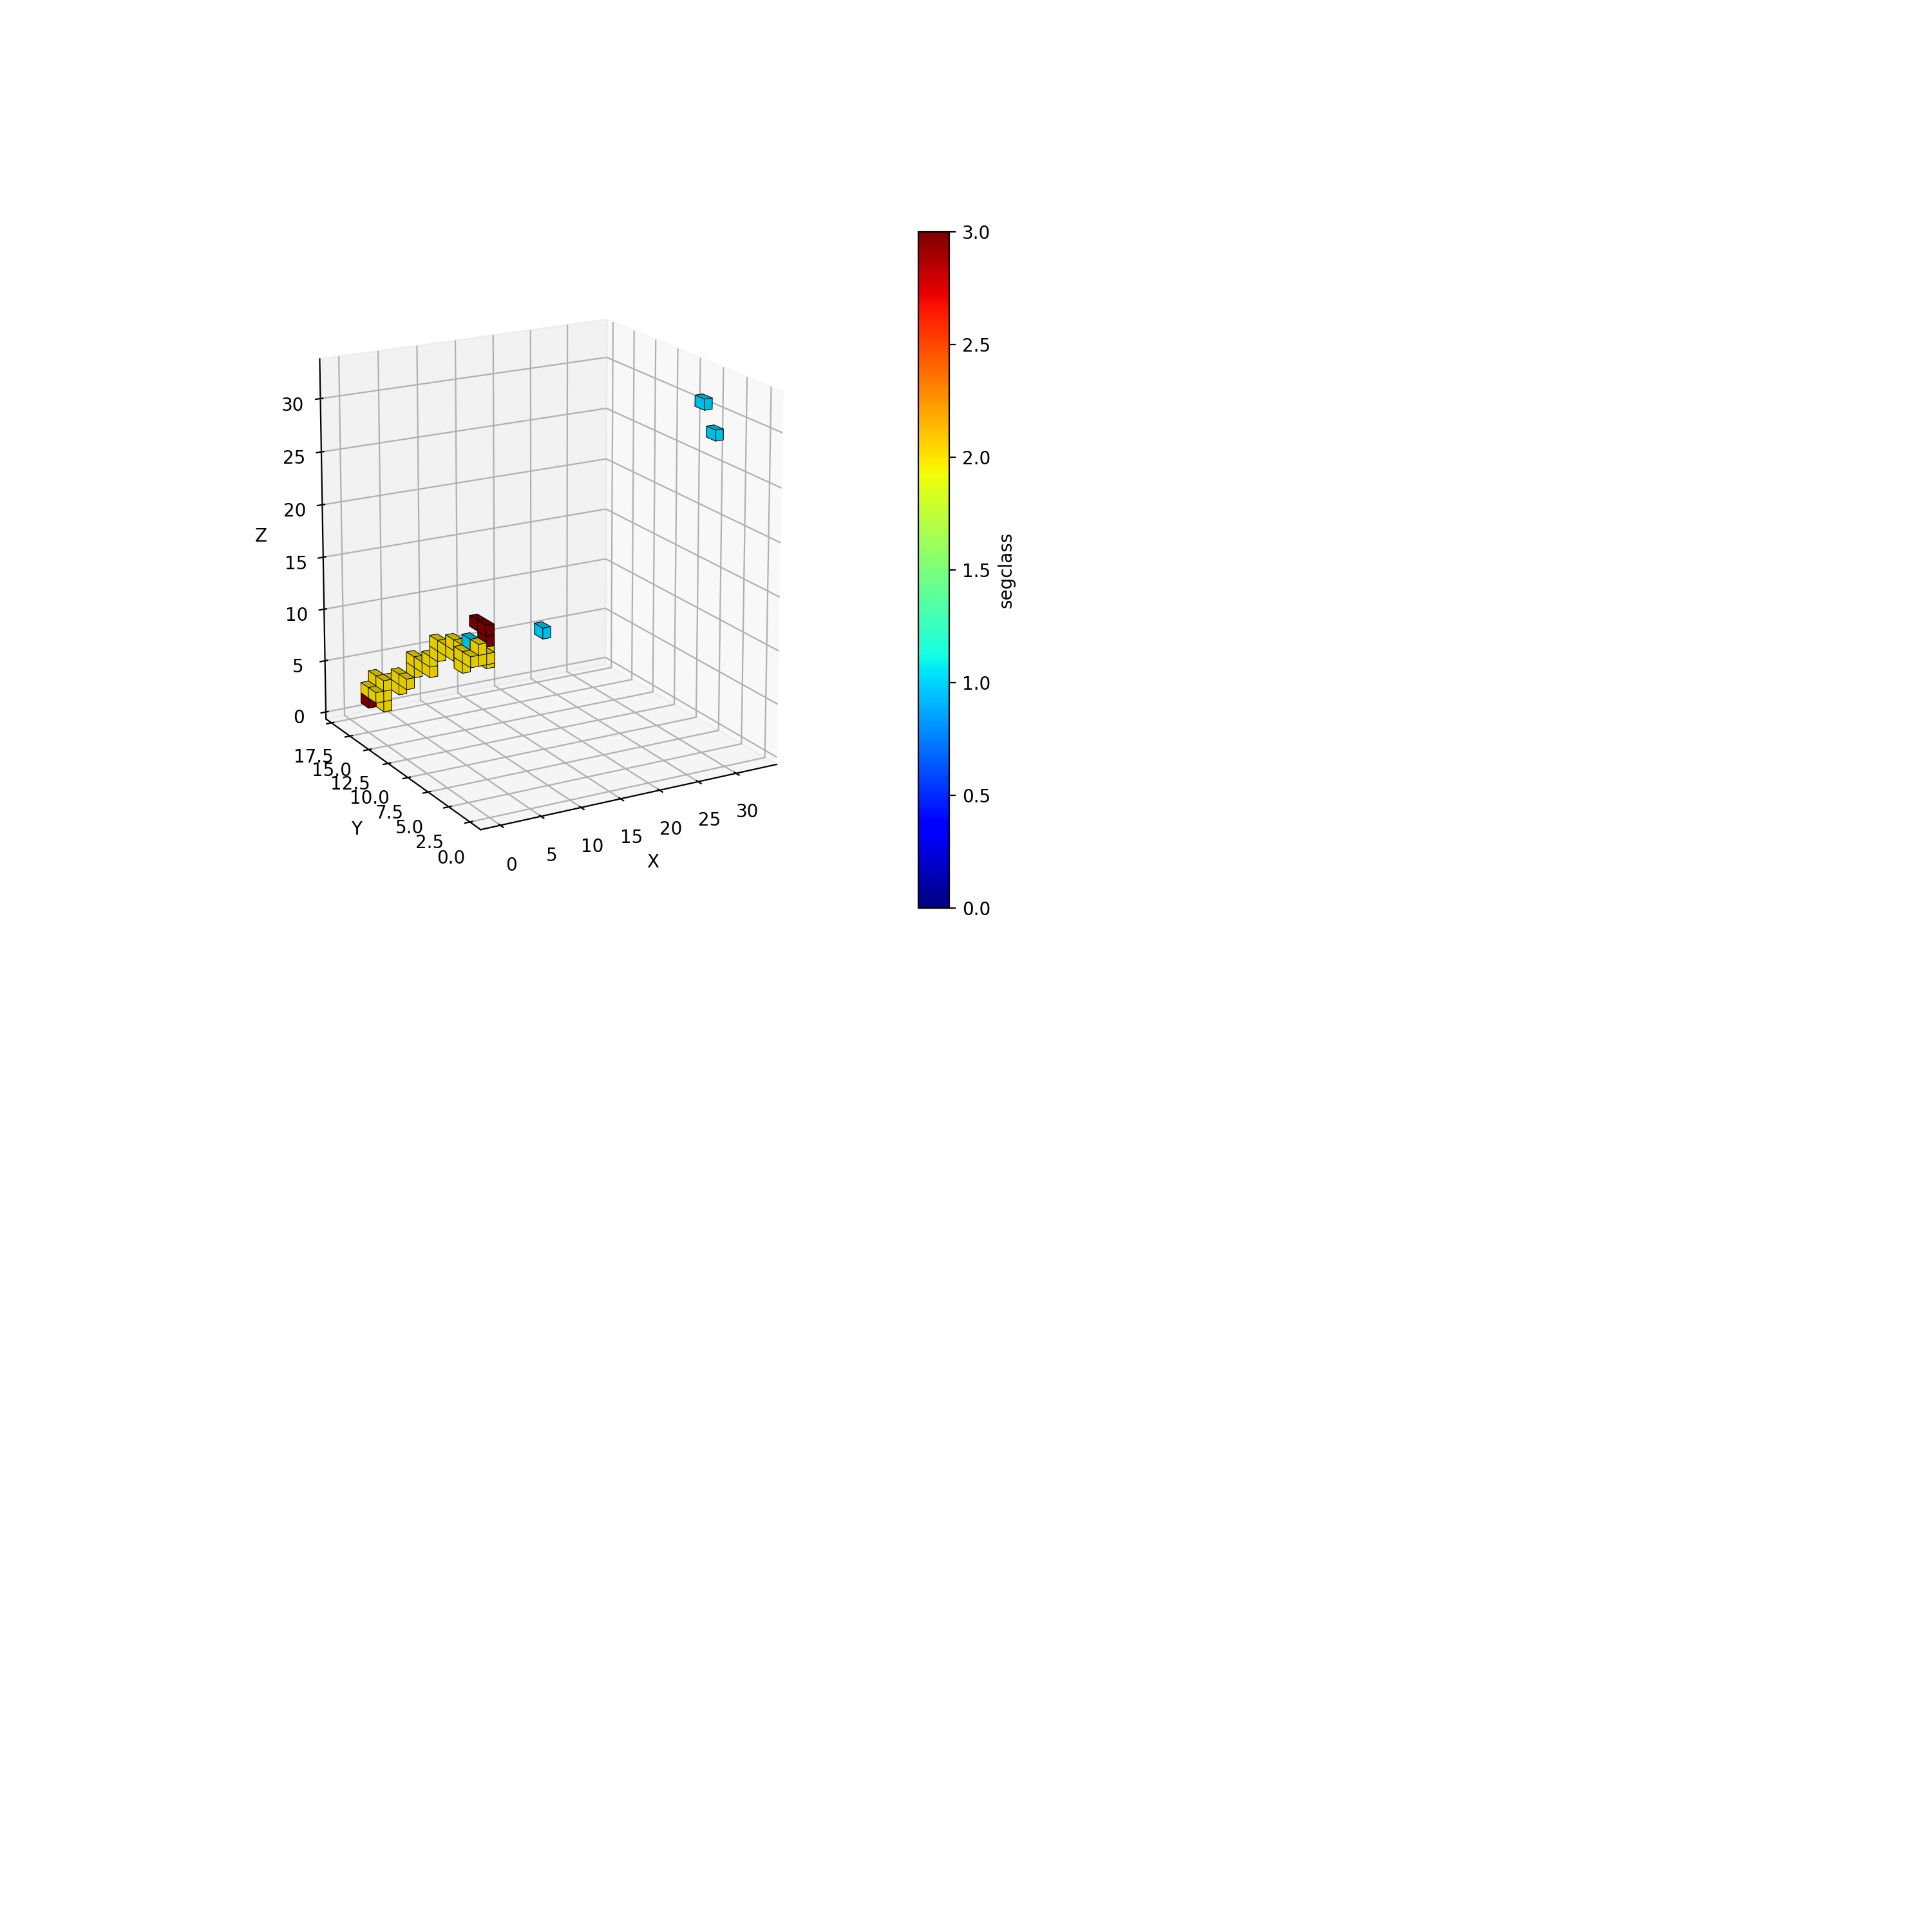

<IPython.core.display.Javascript object>


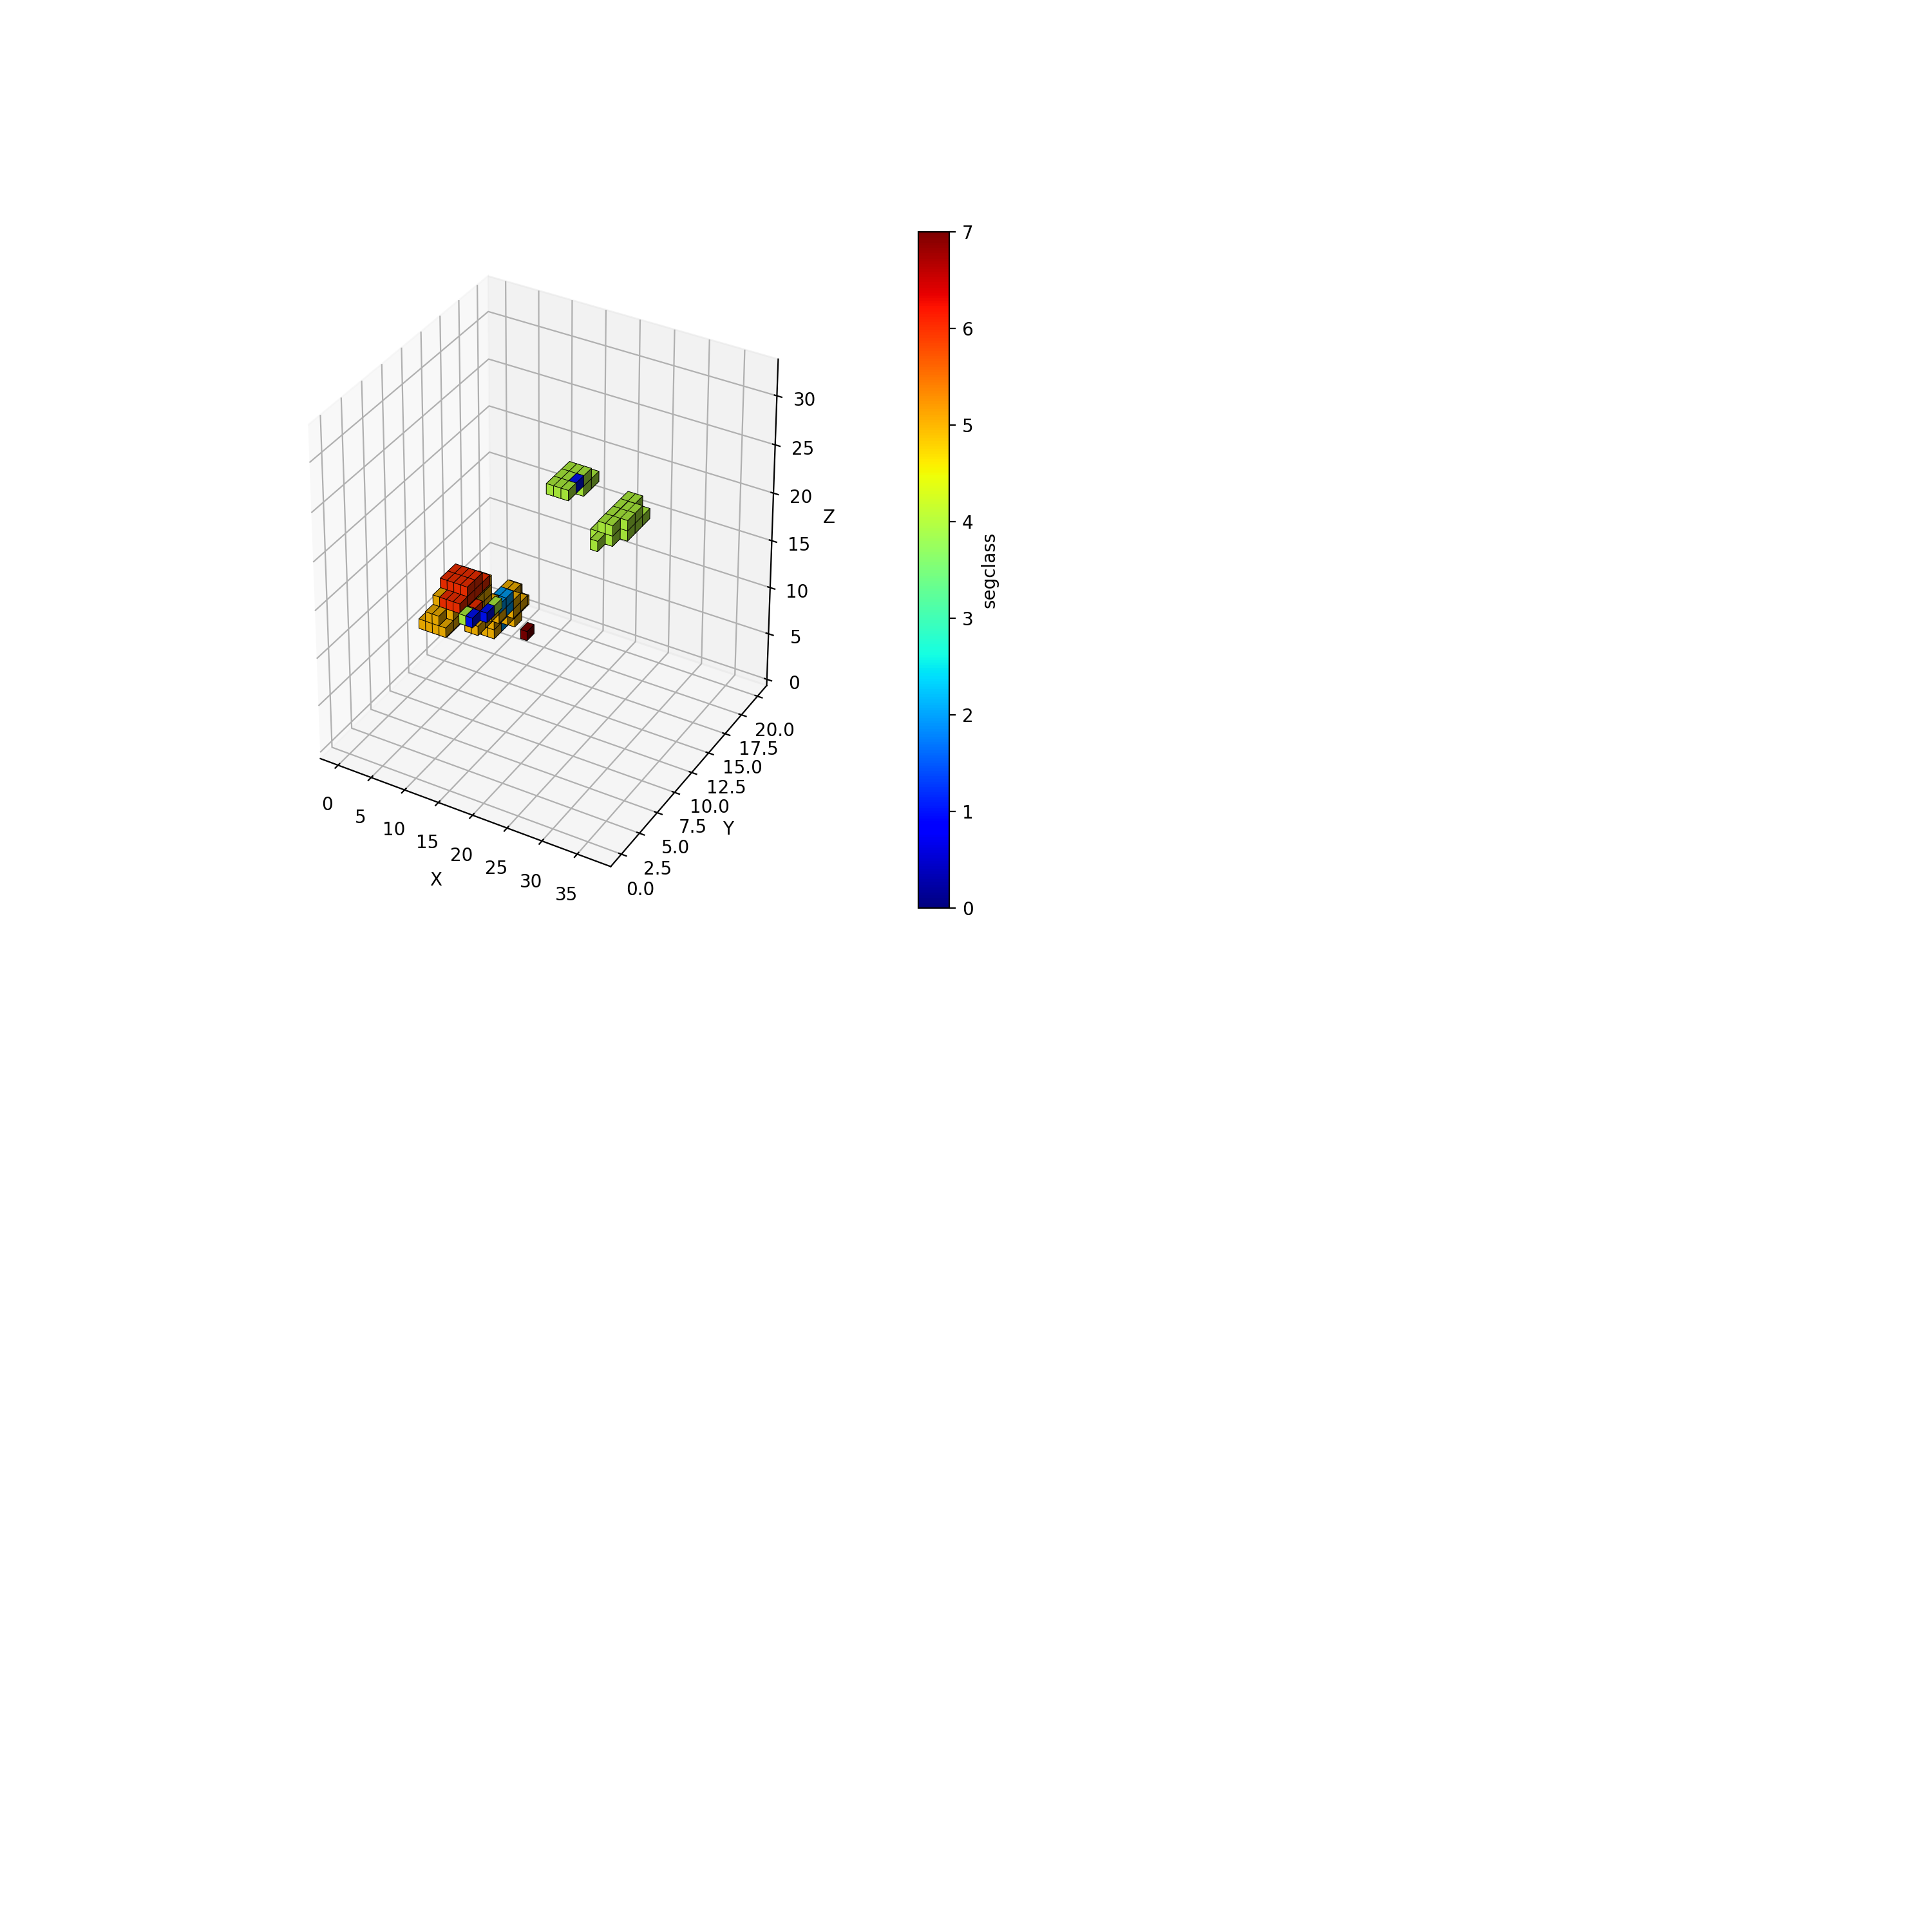

In [54]:
plot_3d_vox(segclass_voxel, value = 'segclass')
plot_3d_vox(labelled_beersheba_voxels[labelled_beersheba_voxels.dataset_id == idx], value = 'segclass', coords = ['xbin', 'ybin', 'zbin'])


# Nuevo fichero con el labelling algo corregido, miramos los eventos que siguen dando mal y saco conclusiones al final :)

## O también puedo ver los eventos que sí salieron bien y compararlos con los del fichero anterior para ver que efectivamente la cosa mejoró :)

In [14]:
from utils.plotting_utils import plot_cloud_voxels_and_hits

In [15]:
new_label_file = '/Users/mperez/NEXT/data_labelling/examples/h5files/prueba_cut24_prueba_correctlabelling.h5'

In [16]:
labelled_MC_voxels_n = dio.load_dst(new_label_file, 'DATASET', 'MCVoxels')
labelled_MC_hits_n   = dio.load_dst(new_label_file, 'DATASET', 'MCHits')
labelled_beersheba_voxels_n = dio.load_dst(new_label_file, 'DATASET', 'BeershebaVoxels')
eventInfo_n = dio.load_dst(new_label_file, 'DATASET', 'EventsInfo')
binsInfo_n  = dio.load_dst(new_label_file, 'DATASET', 'BinsInfo')

Escojo un evento a mano (de los malos)

In [17]:
ind = 931

In [25]:
beersh_event_n = labelled_beersheba_voxels_n[labelled_beersheba_voxels_n.dataset_id == ind]
MC_event_vox_n = labelled_MC_voxels_n[labelled_MC_voxels_n.dataset_id == ind]
MC_event_hits_n = labelled_MC_hits_n[labelled_MC_hits_n.dataset_id == ind]

### Los siguientes outputs son para ver dónde podía seguir fallando el etiquetado

In [26]:
#MC_event_hits_n.x.min(), MC_event_hits_n.x.max(), MC_event_hits_n.y.min(), MC_event_hits_n.y.max(), MC_event_hits_n.z.min(), MC_event_hits_n.z.max()

In [27]:
#MC_event_hits_n[MC_event_hits_n.z < 1]

In [28]:
#MC_event_hits_n[MC_event_hits_n.segclass == 3]

Aquí vamos al archivo fuente para ver cómo iban las partículas y eso...

In [29]:
original_path_n = 'h5files/' + eventInfo_n[eventInfo_n.dataset_id == ind].basename.values[0]
original_id_n = eventInfo_n[eventInfo_n.dataset_id == ind].event_id.values[0]

In [34]:
original_path_n, original_id_n

('h5files/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_6207.root.h5',
 48000596)

In [30]:
original_MC_hits_n = dio.load_dst(original_path_n, 'MC', 'hits')
original_MC_part_n = dio.load_dst(original_path_n, 'MC', 'particles')
original_MC_event_hits_n = original_MC_hits_n[original_MC_hits_n.event_id == original_id_n]
original_MC_event_part_n = original_MC_part_n[original_MC_part_n.event_id == original_id_n]

In [31]:
beersh_event_n

xbin  ybin  zbin    energy  binclass  MC_ener  ratio  segclass  \
116232    14   -31    79  0.000797         1      NaN    NaN         5   
116233    14   -29    81  0.000664         1      NaN    NaN         5   
116234    15   -36    83  0.001290         1      NaN    NaN         4   
116235    15   -35    83  0.003992         1      NaN    NaN         4   
116236    15   -35    84  0.000643         1      NaN    NaN         4   
...      ...   ...   ...       ...       ...      ...    ...       ...   
116393    21   -32    82  0.001486         1      NaN    NaN         5   
116394    21   -32    83  0.000186         1      NaN    NaN         5   
116395    21   -31    81  0.000838         1      NaN    NaN         5   
116396    21   -31    82  0.003628         1      NaN    NaN         5   
116397    21   -31    83  0.000624         1      NaN    NaN         5   

        dataset_id  
116232         571  
116233         571  
116234         571  
116235         571  
116236         571  
...            ...  
116393         571  
116394         571  
116395         571  
116396         571  
116397         571  

[166 rows x 9 columns]

## REVERSE SEARCH

A PARTIR DE AHORA VOY A HACER SORT EN EL SCRIPT PERO POR LOS ARCHIVOS QUE NO TENIA SORTEADOS, LEGGO!!

Cojo y busco en el event info del archivo q uso ahora, la info de otro archivo

In [49]:
reverse_id = 48000369
reverse_path = 'Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_6206.root.h5'

In [56]:
reverse_dat_id = eventInfo_n[(eventInfo_n.event_id == reverse_id) & (eventInfo_n.basename == reverse_path)].dataset_id.values[0]

In [72]:
beersh_event_n = labelled_beersheba_voxels_n[labelled_beersheba_voxels_n.dataset_id == reverse_dat_id]
MC_event_vox_n = labelled_MC_voxels_n[labelled_MC_voxels_n.dataset_id == reverse_dat_id]
MC_event_hits_n = labelled_MC_hits_n[labelled_MC_hits_n.dataset_id == reverse_dat_id]

<IPython.core.display.Javascript object>


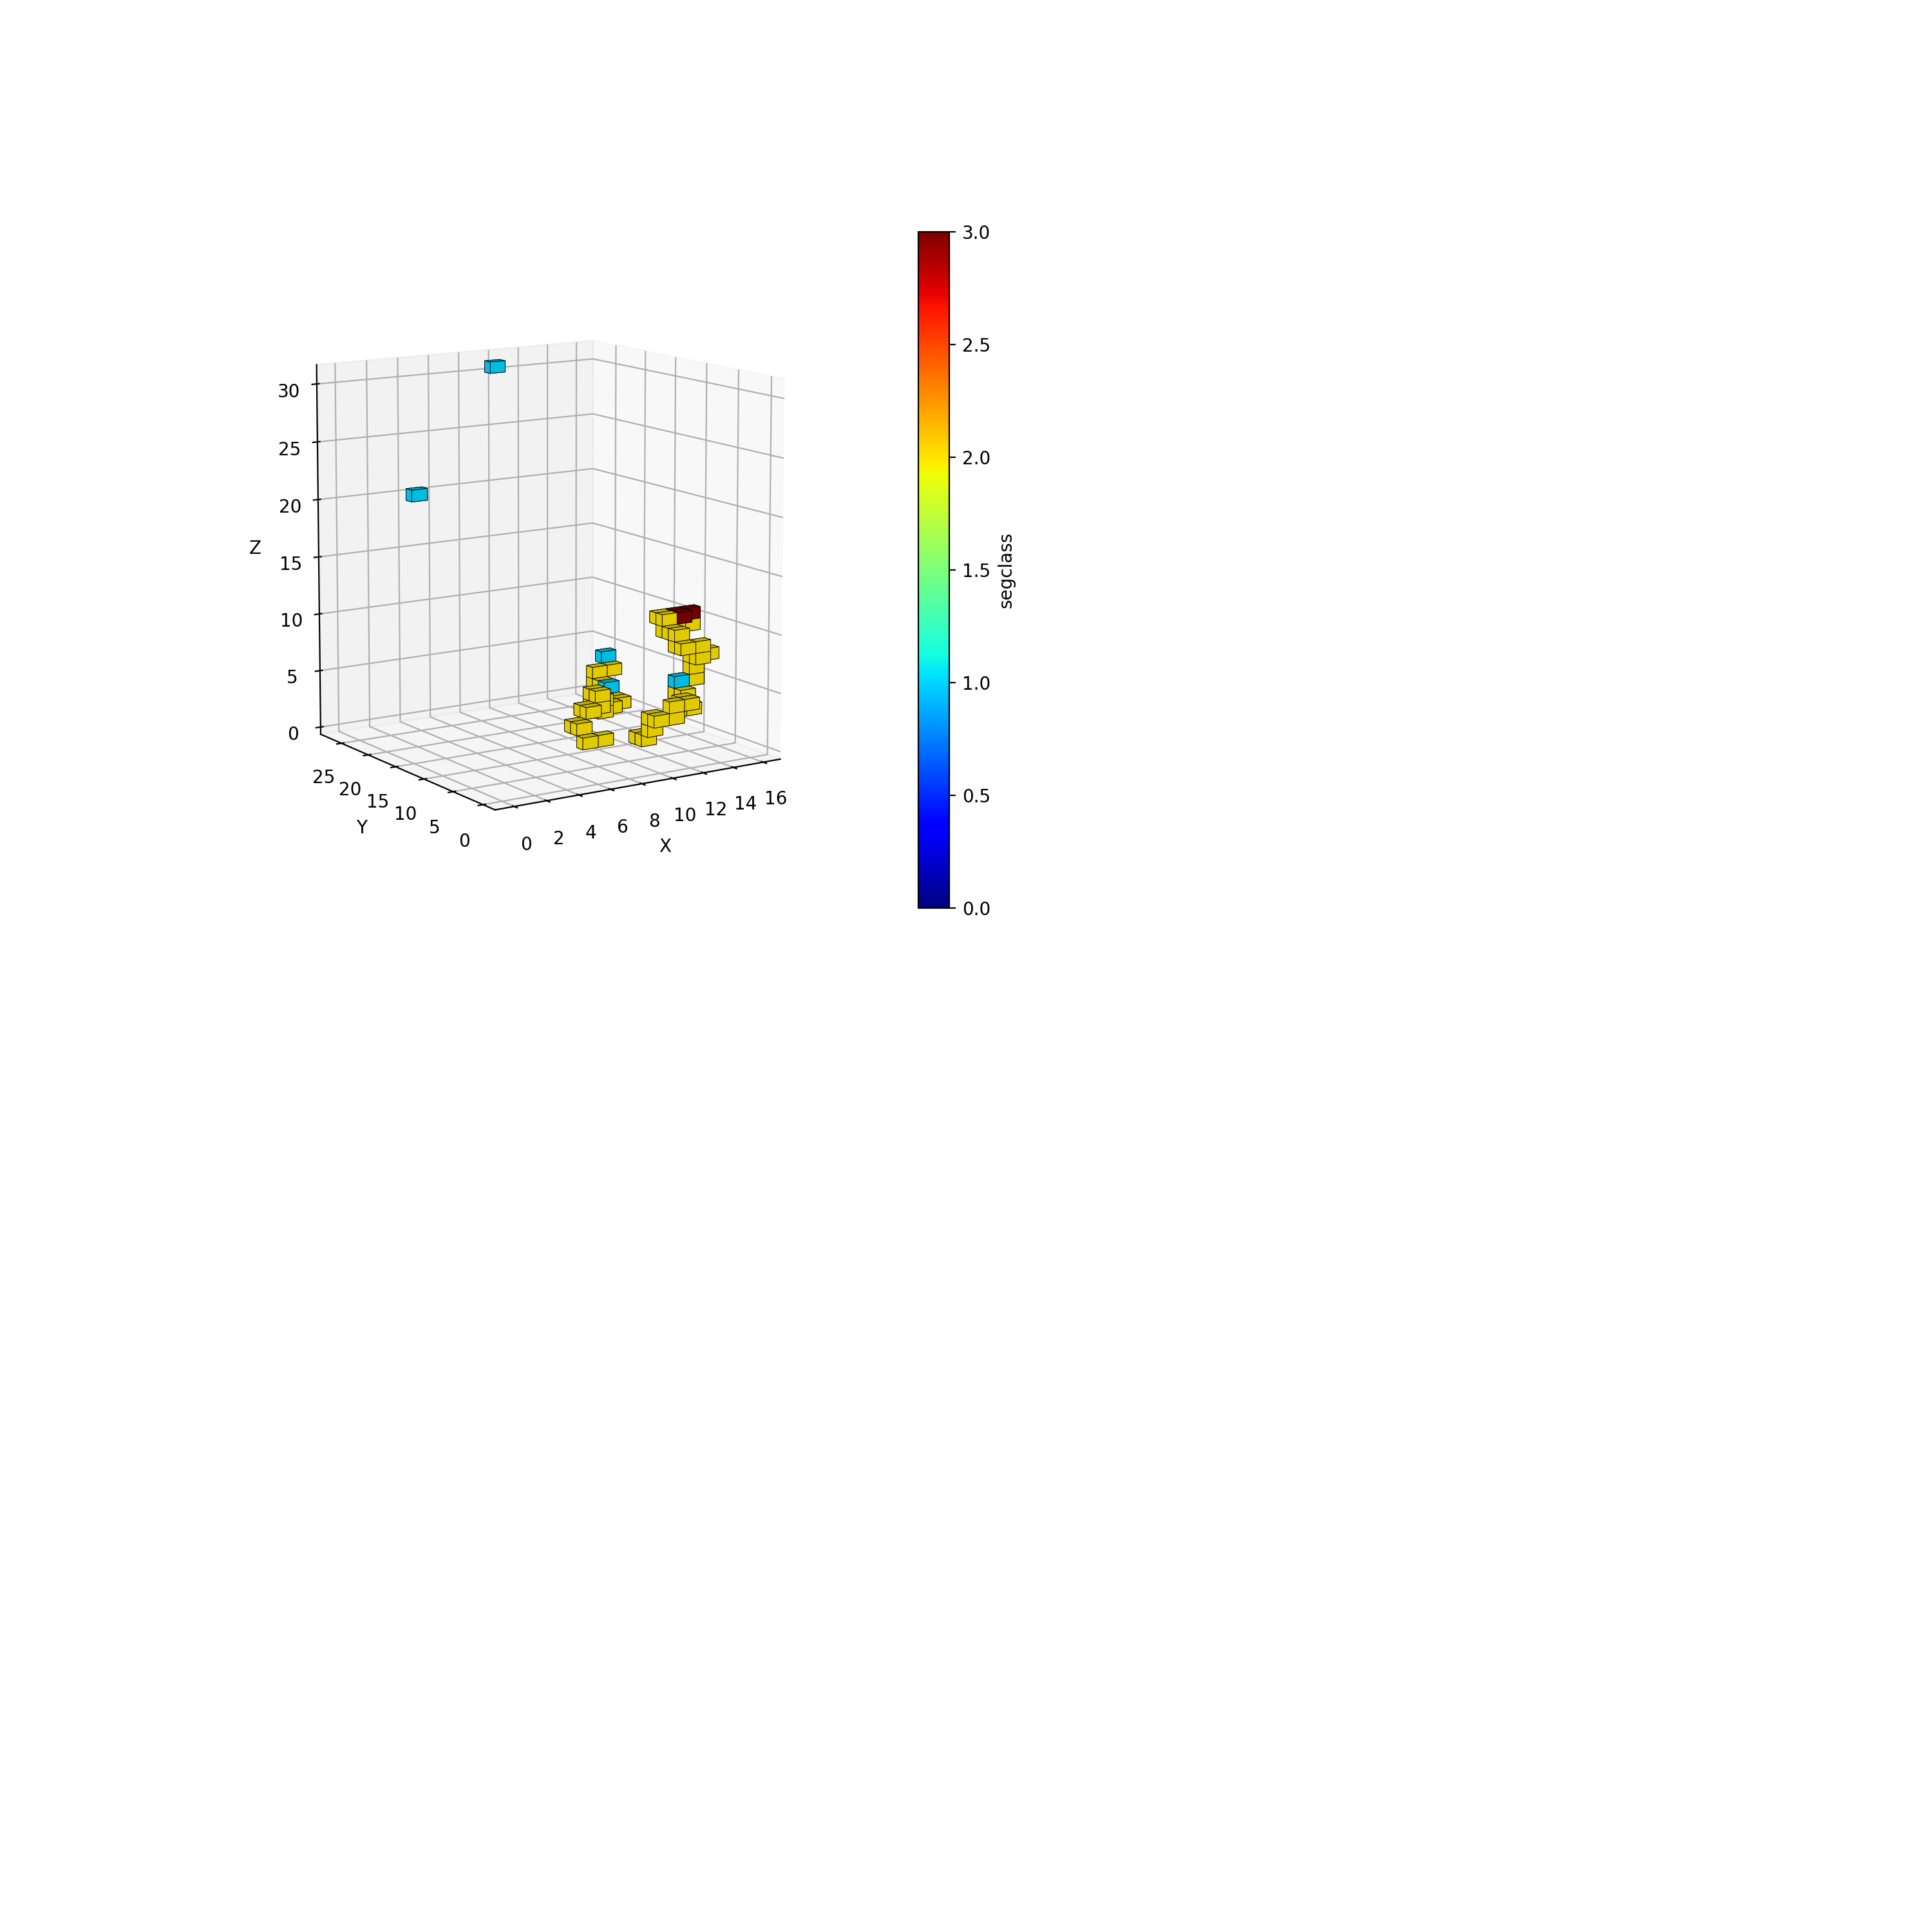

<IPython.core.display.Javascript object>


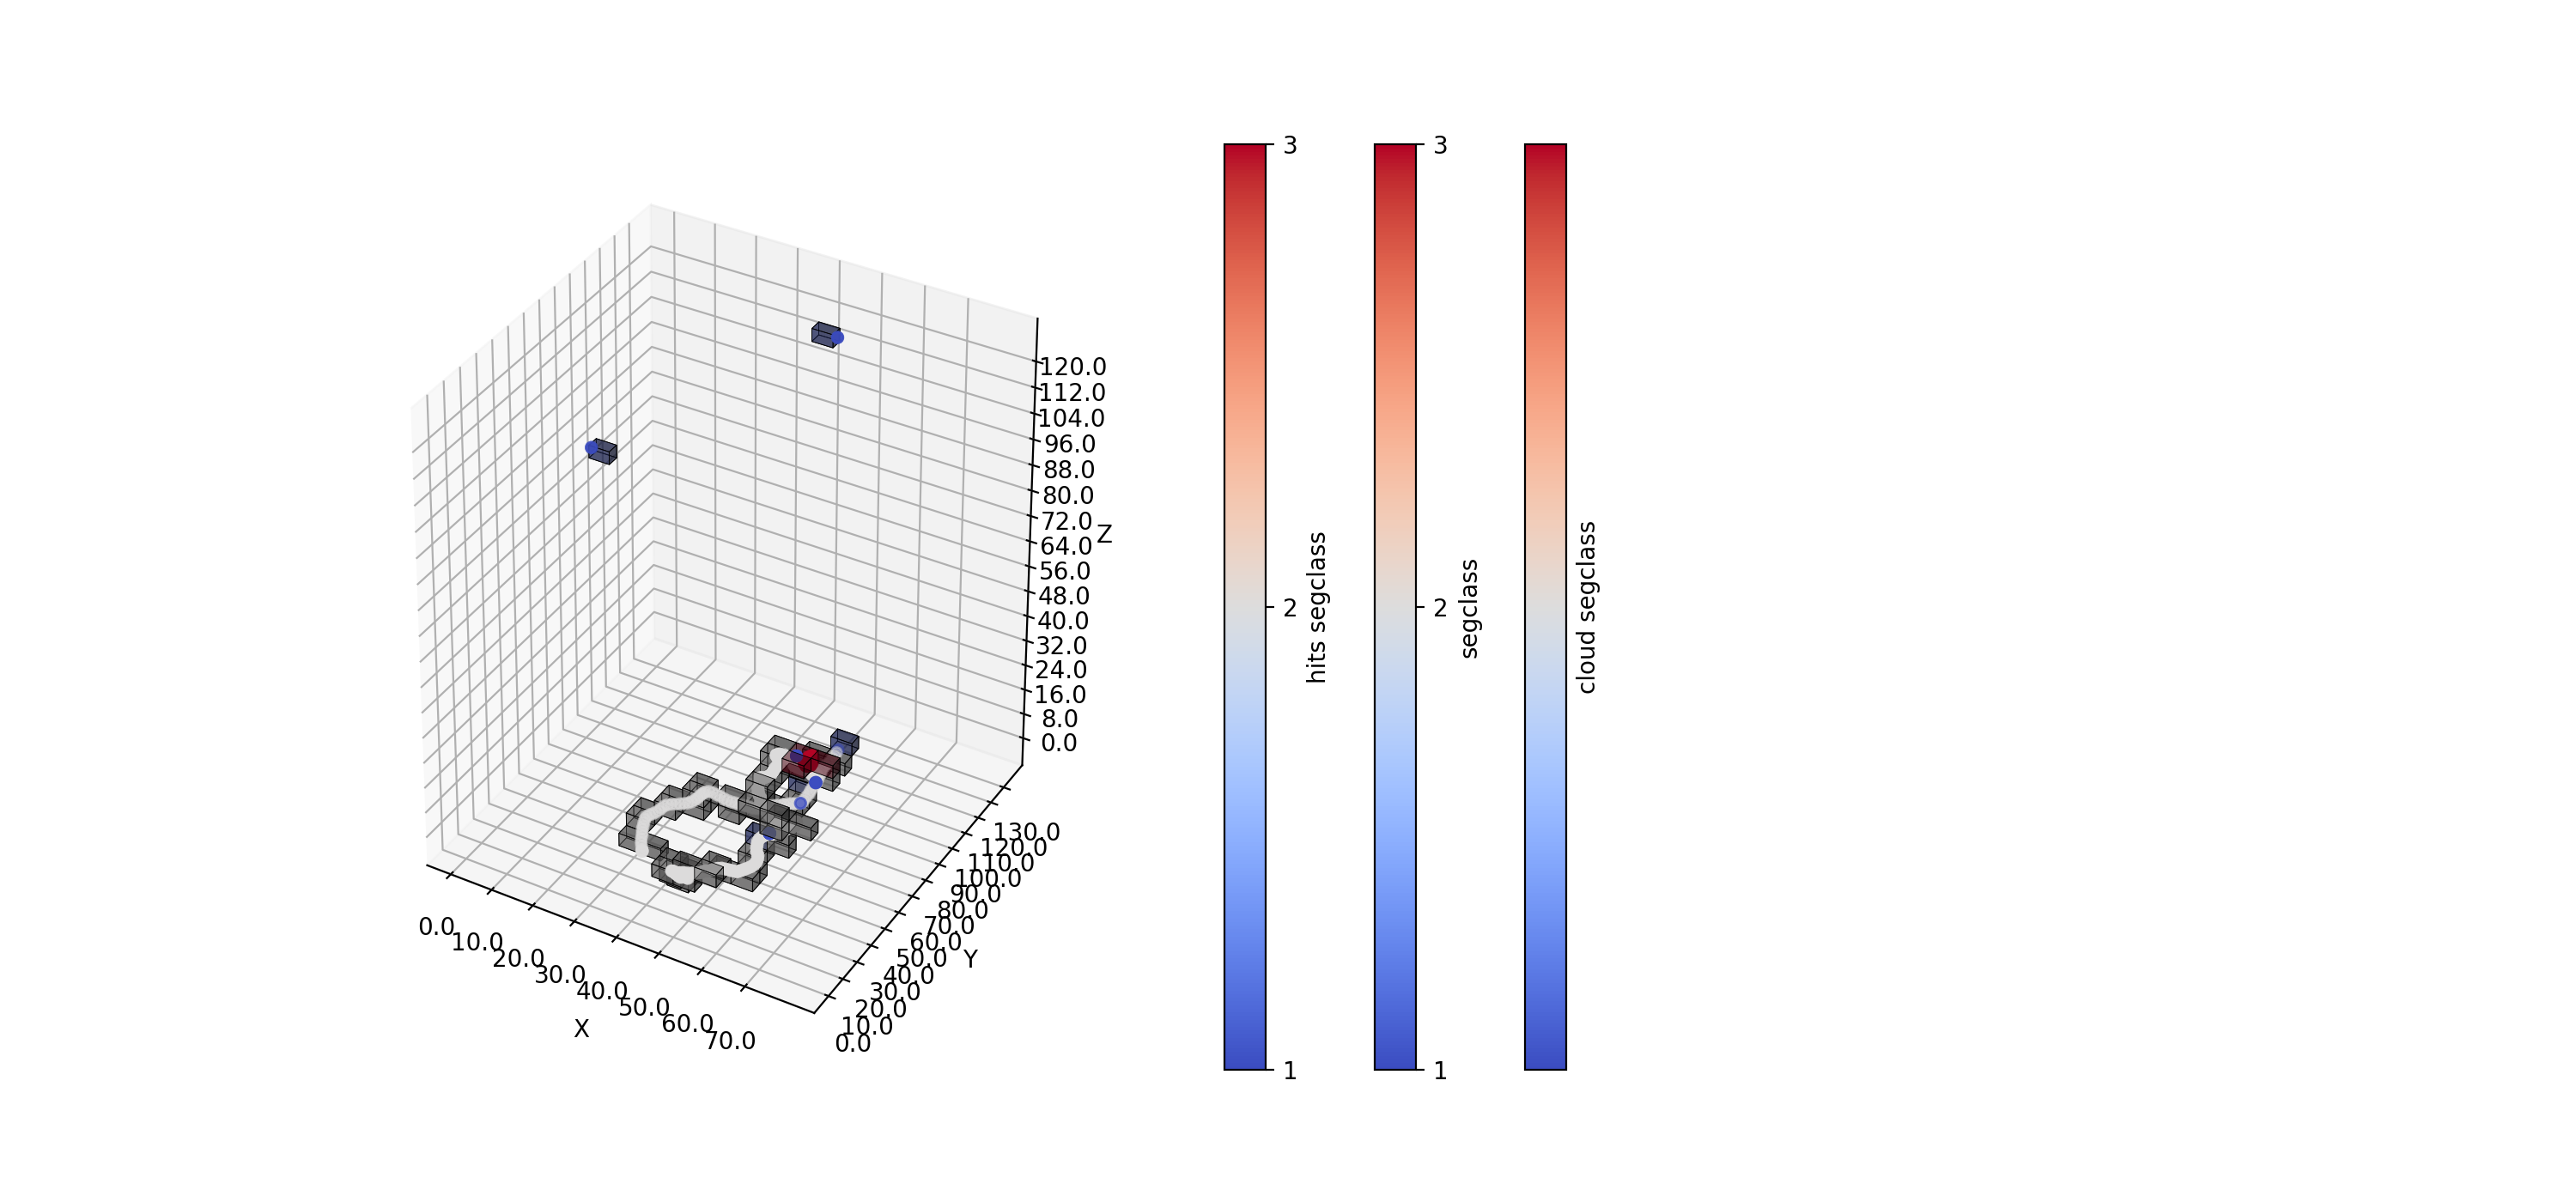

<IPython.core.display.Javascript object>


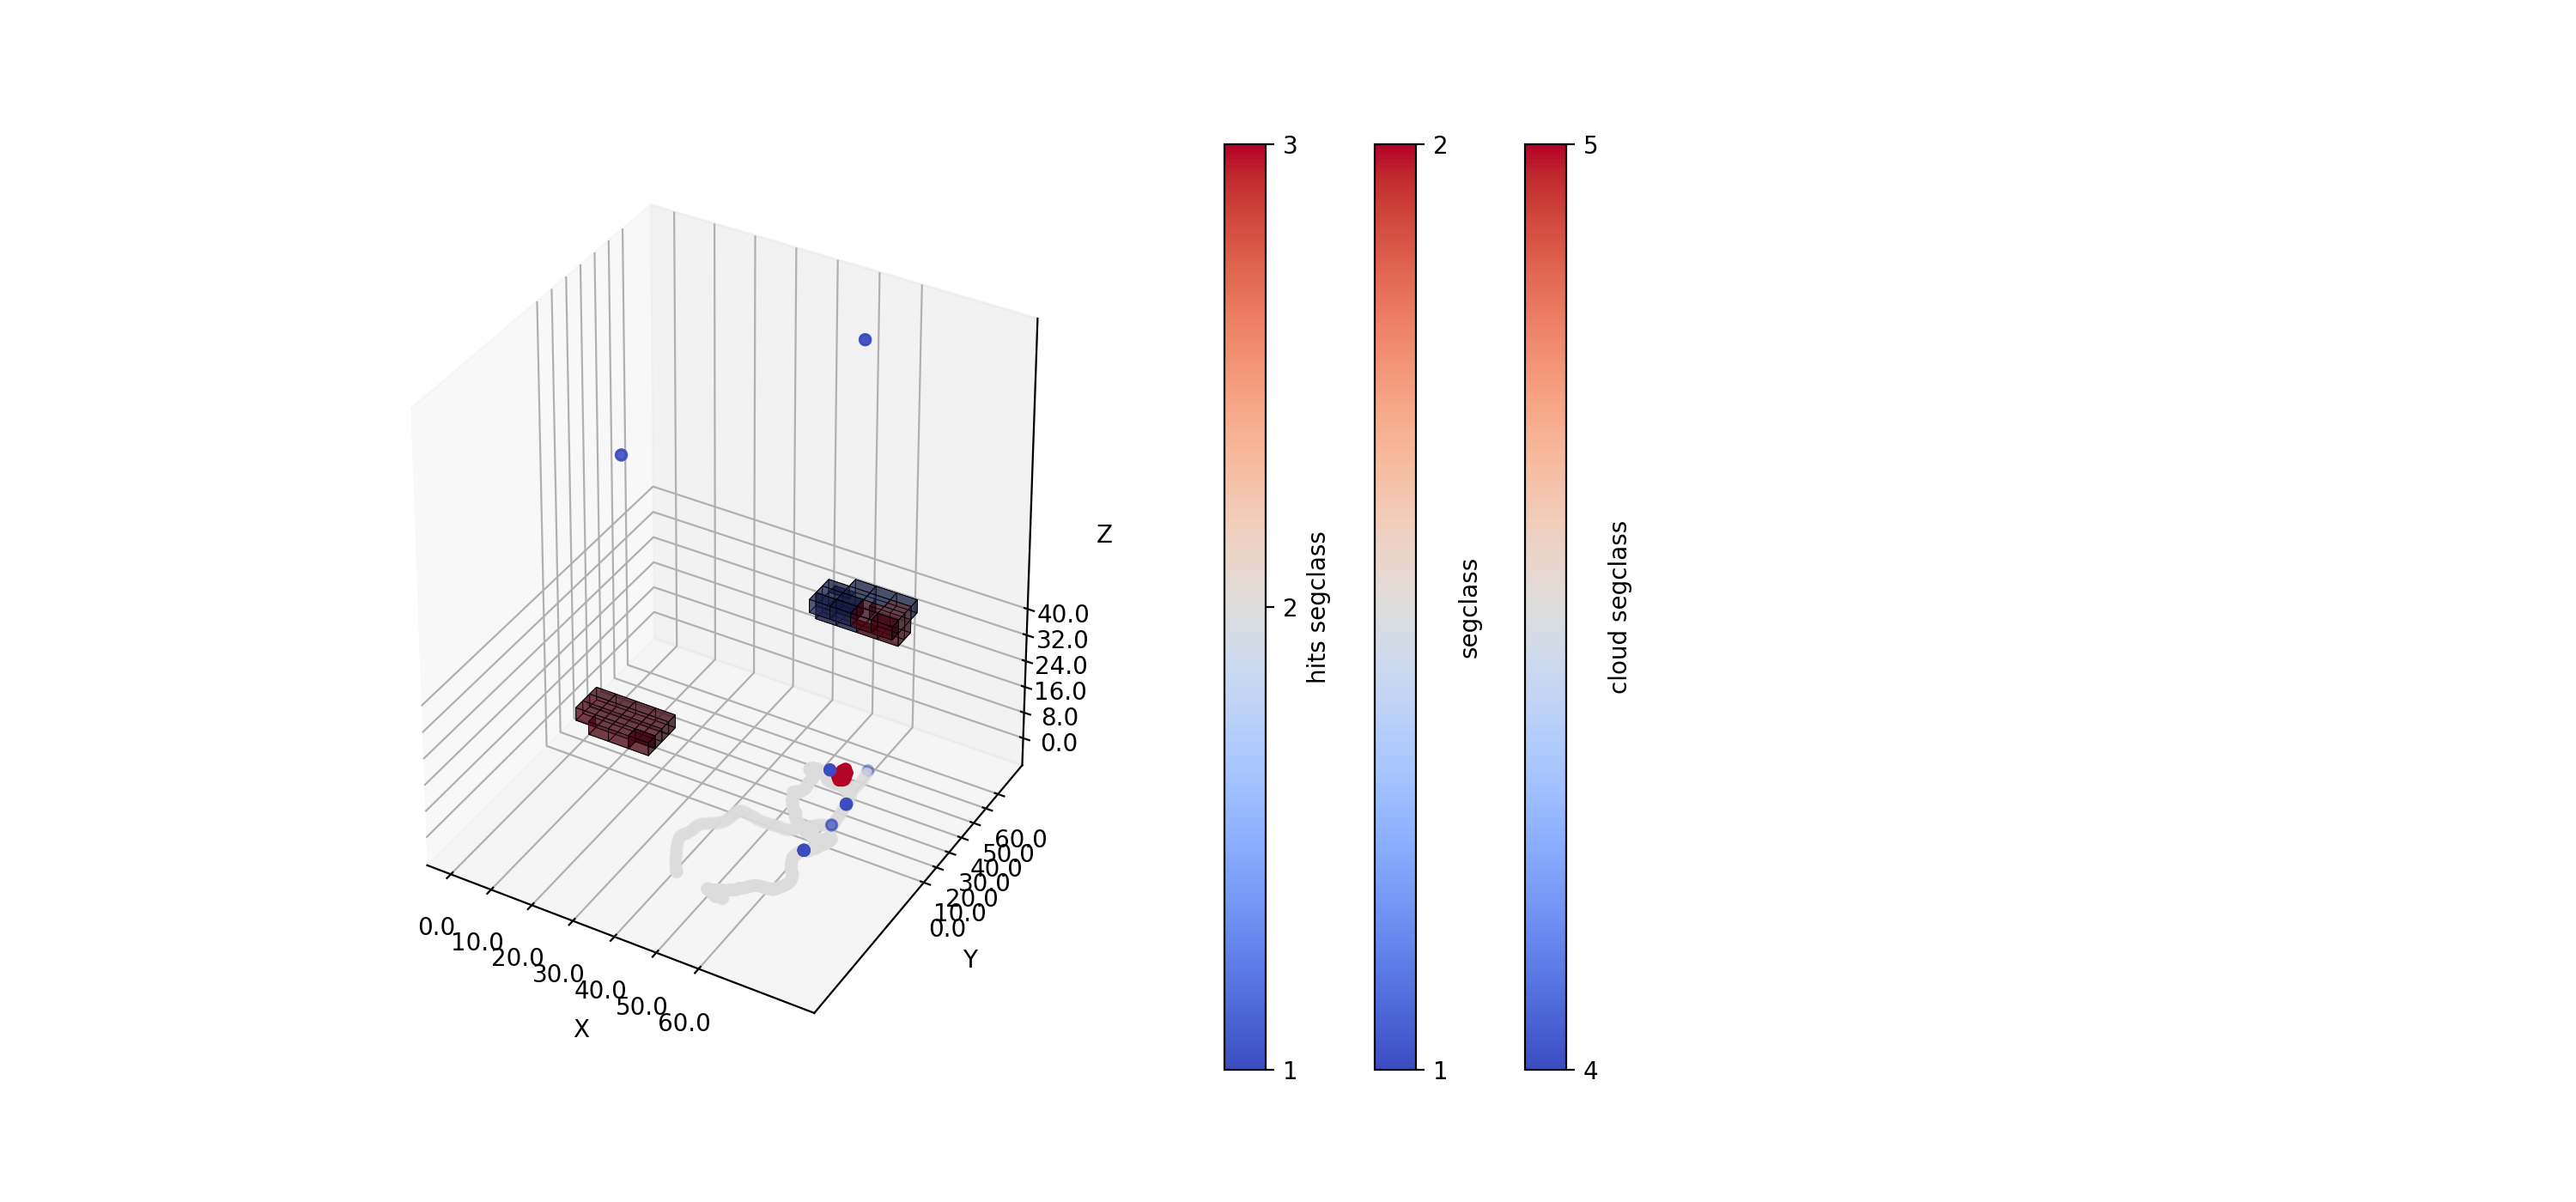

In [73]:
%matplotlib notebook
#plot_3d_vox(event_MC_vox, value = 'segclass')
#plot_3d_hits(original_MC_event_hits_n, value = 'particle_id')
plot_3d_vox(MC_event_vox_n, value = 'segclass')
plot_cloud_voxels_and_hits(MC_event_vox_n, MC_event_hits_n, voxel_size, coords = ['x', 'y', 'z'], opacity = [0.5, 0.5, 1])
plot_cloud_voxels_and_hits(beersh_event_n, MC_event_hits_n, voxel_size, coords = ['xbin', 'ybin', 'zbin'], opacity = [0.5, 0.5, 1])




# Conclusiones

## 1e, <1blob
* 931: sí tiene voxeles blob, pero quizás falla algo porque hay 2 trazas... la traza está partida. No es el corte fiducial porque ya está partida en el MC original (el que hay en los ficheros de beersheba), y no es un error en el labelling porque la partícula es el electrón que deja la traza. Entonces la discontinuidad vendrá del MC en sí? Quizás excedió los límites del detector? PARECE que si porque en z los hits se acercan peligrosamente a 0... VEO QUE EL ARREGLO SERÍA ELIMINAR ESTE TIPO DE EVENTOS ''INCOMPLETOS'' O CORTADOS

* 1102, 2936: simplemente no son lo suficientemente energéticos como para ganarle a sus compañeros PERO exceden el threshold que los marcaría como small blobs (yo puse 0.1 y los eventos tienen como 0.14), por tanto no aparece ninguno.... SUBIR ALGO THRESHOLD

## 1e, >1blob
* 1, 28, 51, 61, 68, 120, 135, 153: no veo nada extraño (a no ser que sea porque hay voxeles conectados solo por una arista, pero ni todos son así) NO VEO ARREGLO

* 4, 33, 145, 146, 175, 185: se retuerce un poco, puede dar lugar a confusión pero no sé muy bien como en todos los casos... en algunos parece porque el propio blob al retorcerse desconecta la traza pero el blob permanece entero igualmente (es decir, no veo que se desoncecte y dé 2 blobs) NO VEO ARREGLO

* 42: se ve que hay dos grupos de blob pero realmente están conectados (al menos por la mínima distancia)... qué pasa, que quizás en esa aglomeración no debería ni aparecer el voxel ese other que interfiere... Es difícil además marcarlo como small blob porque la energía es de 0.35 (al menos en el 42) NECESARIO ARREGLO, PENSAR

* 48, 181, 184: similar al 42 pero el voxel other SÍ llega a desconectar la traza... esto sí es un issue claro a mejorar NECESARIO ARREGLO, PENSAR

## 2e, <2blob

* 37, 531, 567, 1032, 1087: resulta que una de las dos partículas deja sólo 2 (4) hits, entonces no se etiqueta ninún hit como blob ya que no se cumple la condición del 25% de la traza total de esa partícula, por tanto no hay nada que marcar como small blob (porque lo sería obviamente) y en los voxeles no se ve representado. Quizás poner que si la traza tiene menos de X hits, hay que marcarla toda como blob en los hits de MC?? O poner que si la traza es menos de cierto porcentaje de la energía de las dos trazas (rollo sumando electron y positron), se marquen sus hits como blob?? Lo demás ya está hecho, es cosa de lo de small blob. Las energías de cada traza son (sumando los hits, aunque se puede ir a mirar la columna de kin_energy del df de partículas, que es algo mayor pq supongo que pierden energía de otras formas q no son hits, si no ionizando atomos etc) 1.3 / 0.02 (1.25 / 0.03, 1.4 / 0.02, 1.2 / 0.01......)... Voy a hacer algo q me busque este ''ratio'' automáticamente entre los eventos que estoy seleccionando NECESARIO ARREGLO, PENSAR... PERO YO ME PREGUNTO... TIENE SENTIDO ARREGLAR ESTO? ES DECIR, SON EVENTOS ANÁLOGOS PRÁCTICAMENTE A UN SINGLE ELECTRON... VALE LA PENA BUSCAR AQUÍ OTRO BLOB? O SEA LO IDEAL SERÍA QUE SÍ PERO SIENDO REALISTAS, ES POSIBLE ENCONTRAR UN BLOB AHÍ????

* 110, 242, 413, 616, 707, 1069, 1089: una de las partículas supera el threshold que puse para small blob, tal y como pasa en 1e, <1blob (estoy viendo que suelen tener 0.14 o menos incluso...) SUBIR ALGO EL THRESHOLD

* 420, 571, 575: la traza se retuerce y los blobs acaban tan cerca que se unen NO VEO ARREGLO

* 686, 866: no veo que haya fallo, no llegan a juntarse, pero sí es cierto que la traza es algo retorcida y puede que por eso el algoritmo esté confuso

## 2e, >2blob
* 197, 358, 632, 682, 715, 731, 750, 787, 966, 1038, 1158, 1167, 1190, 1221, 1243, 1259, 1263: no veo más de 2 blobs. algunas puede que sean fruto de que se retuerza algo la traza, o de que estén juntas pero solo compartan una arista del cubo... pero más que eso ni idea
* 1250: este es de los q para mi formaría un conjunto (con mi algoritmo que junta los que se separan hasta una distancia de raiz(3), es decir, terceros vecinos), pero se ve más claramente que el algoritmo de JA puede estar interpretando otra cosa...)